# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- <b>Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?</b><br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [ ]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the matches data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

In [4]:
matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}

### Preprocessing

These DataFrames will be used to do a total final analysis.

In [5]:
total_passes_counts = pd.DataFrame()
total_goals_passes_counts = pd.DataFrame()
total_comparison = pd.DataFrame()
competition_wins = pd.DataFrame()

In [6]:
events_df['England'][20:25]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
20,8,Head pass,[{'id': 1802}],370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",2499719,Pass,1609,1H,35.685082,82,177959184
21,8,Head pass,[{'id': 1801}],14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",2499719,Pass,1631,1H,36.661264,82,177959204
22,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,1H,38.191874,13,177959205
23,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",2499719,Duel,1609,1H,38.191874,13,177961219
24,8,Smart pass,"[{'id': 901}, {'id': 1802}]",14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",2499719,Pass,1631,1H,39.940109,86,177959206


Each event can contain 0 or more tags that provide more information about the event. For example, in the case of a pass, whether the ball was kicked with the right or left foot. Since the analysis will consider events that lead to a goal, and these are identified with the tag '101', to allow for easier computation, it was preferred to transform the tags from a list of dictionaries to a simple list of integers.

In [7]:
for events in events_df.values():
    events['tags'] = events['tags'].apply(extract_tags)

In [8]:
events_df['England'][20:25]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
20,8,Head pass,[1802],370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",2499719,Pass,1609,1H,35.685082,82,177959184
21,8,Head pass,[1801],14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",2499719,Pass,1631,1H,36.661264,82,177959204
22,1,Ground loose ball duel,"[703, 1801]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,1H,38.191874,13,177959205
23,1,Ground loose ball duel,"[701, 1802]",0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",2499719,Duel,1609,1H,38.191874,13,177961219
24,8,Smart pass,"[901, 1802]",14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",2499719,Pass,1631,1H,39.940109,86,177959206


In football, a "pass chain" typically refers to a sequence of passes made by players of a team during a specific action or possession. It is a way to describe the flow of the ball movement through passing within the team.

This definition can be subjective and open to various interpretations. For example, if an opponent deflects the ball but the team in possession retains it, does the pass chain break? If there is a duel and the ball is deflected fortuitously but the team in possession keeps it, is it considered the start of a new pass chain? As a personal interpretation of this topic, when the aforementioned events occur, the pass chain continues. For this reason, the analysis presented in this notebook compares "unclean" events, considering all events, with "clean" events, which are the remaining events after removing touches (https://dataglossary.wyscout.com/touch/) and duels (https://dataglossary.wyscout.com/duel/).

In general, all graphs show a power law distribution.
Specifically, focusing on the distribution of the number of passes before a shot or goal obtained from the "unclean" events, its distribution shows that most of the events considered occur without a previous pass chain. This suggests that most shots and goals are made either when an opponent loses possession or when the player who will attempt a personal action recovers the ball. The number of shots taken with only one previous pass in the chain is also remarkable: this category includes free kicks, corner kicks, and, in general, crosses made after a foul, or even passes made by a player who recovers the ball and then tries to make an assist for the player who will then shoot the ball.

On the other hand, considering the dataset "cleaned" of the previously mentioned events, it can be noted that the distribution of passes is clearly more spread out and gives the power law a very long tail, correctly joining pass chains that would otherwise have been considered broken in the first analysis.

At the end of the analysis of each competition, there is also a graph showing the number of matches won by each team in relation to the pass chains made before scoring a goal. In particular, what was done was to check, for each goal scored by the team that won the match, the number of passes made before the shot. It was considered that 8 was the right number that could be used as a threshold to understand whether a pass chain is long or short.

Following the analysis carried out, the victories of each team were divided into 3 classes:

- If the match was won with all goals scored with a short pass chain before the shot, then the victory is inserted into class 0;

- If the match was won with goals scored with both a short and long pass chain before the shot, then the victory is inserted into class 1;

- If the match was won with all goals scored with a long pass chain before the shot, then the match is inserted into class 2.

The following function is used for analyzing the pass chains distribution before a shot and a goal, calculating the results with both the clean and uncleaned dataset.

In [9]:
def pass_chain_analysis(competition_area, competition_name):
    competition_events = events_df[competition_area]
    competition_matches = matches_df[competition_area]

    # returns a dictionary with the number of passes before a shot for each match and each event
    passes_before_shot = get_passes_before_shot(competition_events, competition_matches)
    # returns a dataframe with the number of passes before a shot for each match
    competition_passes_counts = count_passes_before_shot(passes_before_shot)
    # add a column to the dataframe to specify if the event is a duel or not in order to make the comparison
    competition_passes_counts['duel'] = True

    # returns a dataframe with the number of passes before a goal for each match
    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    # retrieves only the goals caused by a shot
    goals = goals[goals['subEventName'] == 'Shot']

    # retrieves, from the previous dictionary, the number of passes before a goal for each match
    passes_before_goal = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        team_id = row['teamId']
        winner = competition_matches[competition_matches['wyId'] == match_id]['winner'].values[0]
        
        passes_before_goal[match_id, team_id, event_sec, winner] = passes_before_shot[match_id, team_id, event_sec, winner]

    # returns a dataframe with the number of passes before a goal for each match
    competition_goals_passes_counts = count_passes_before_shot(passes_before_goal)
    competition_goals_passes_counts['duel'] = True

    # this part is the same as the previous computation but removing the duels (specifically, all the events with eventId equal to 1
    # and subEventId equal to 11, 12 or 13)

    competition_events = competition_events[((competition_events['eventId'] != 1) & (~competition_events['subEventId'].isin([11, 12, 13])))].reset_index(drop=True)
    competition_events = competition_events[((competition_events['eventId'] != 7) & (competition_events['subEventId'] != 72))].reset_index(drop=True)

    passes_before_shot_no_duel = get_passes_before_shot(competition_events, competition_matches)
    competition_passes_counts_no_duels = count_passes_before_shot(passes_before_shot_no_duel)

    competition_passes_counts_no_duels['duel'] = False

    goals = competition_events[competition_events['tags'].apply(lambda x: 101 in x)]
    goals = goals[goals['subEventName'] == 'Shot']

    passes_before_goal_no_duel = {}
    for index, row in goals.iterrows():
        match_id = row['matchId']
        event_sec = row['eventSec']
        team_id = row['teamId']
        winner = competition_matches[competition_matches['wyId'] == match_id]['winner'].values[0]
        
        passes_before_goal_no_duel[match_id, team_id, event_sec, winner] = passes_before_shot_no_duel[match_id, team_id, event_sec, winner]

    competition_goals_passes_counts_no_duels = count_passes_before_shot(passes_before_goal_no_duel)
    competition_goals_passes_counts_no_duels['duel'] = False
    
    competition_passes_counts = pd.concat([competition_passes_counts, competition_passes_counts_no_duels])
    competition_goals_passes_counts = pd.concat([competition_goals_passes_counts, competition_goals_passes_counts_no_duels])

    competition_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels.rename(columns={'duel': 'Goal'}, inplace=True)
    competition_goals_passes_counts_no_duels['Goal'] = True

    comparison_goals_passes_counts = pd.concat([competition_passes_counts_no_duels, competition_goals_passes_counts_no_duels])

    # plots
    plot_histogram_pass_chain(competition_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in the %s' %competition_name)
    plot_histogram_pass_chain(competition_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in the %s' %competition_name)
    plot_histogram_comparison_pass_chain(comparison_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in the %s (with no duels)' %competition_name)

    # analyze the probability of winning a match given the number of passes before a goal
    competition_wins = winning_probability(passes_before_goal_no_duel, 8)

    #update the total dataframes
    return competition_passes_counts, competition_goals_passes_counts, comparison_goals_passes_counts, competition_wins

The following function is used to sum up all the distributions of the different championships that have been analyzed.

In [10]:
def total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison, competition_wins):
    total_passes_counts = total_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_goals_passes_counts = total_goals_passes_counts.groupby(['Passes', 'duel'])['count'].sum().to_frame().reset_index()
    total_comparison = total_comparison.groupby(['Passes', 'Goal'])['count'].sum().to_frame().reset_index()
    
    plot_histogram_pass_chain(total_passes_counts, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Number of Passes Before Shot in all the competitions')
    plot_histogram_pass_chain(total_goals_passes_counts, 'Passes', 'count', 'Number of Passes Before a goal', 'Count', 'Number of Passes Before a goal in all the competitions')
    plot_histogram_comparison_pass_chain(total_comparison, 'Passes', 'count', 'Number of Passes Before Shot', 'Count', 'Comparison between shots and goals in all the competitions')
    total_winning_probability_plot(competition_wins, 8)

### Italian pass chains analysis

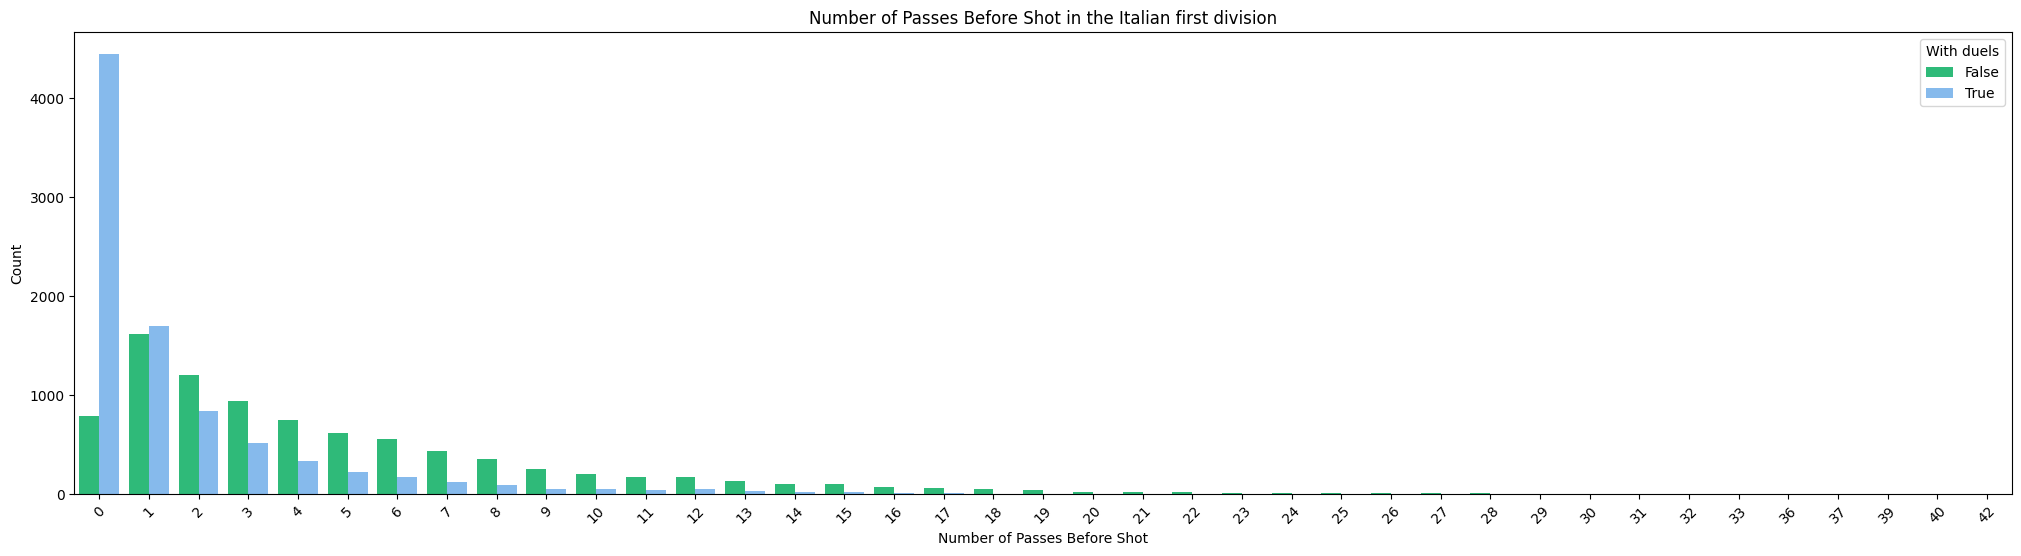

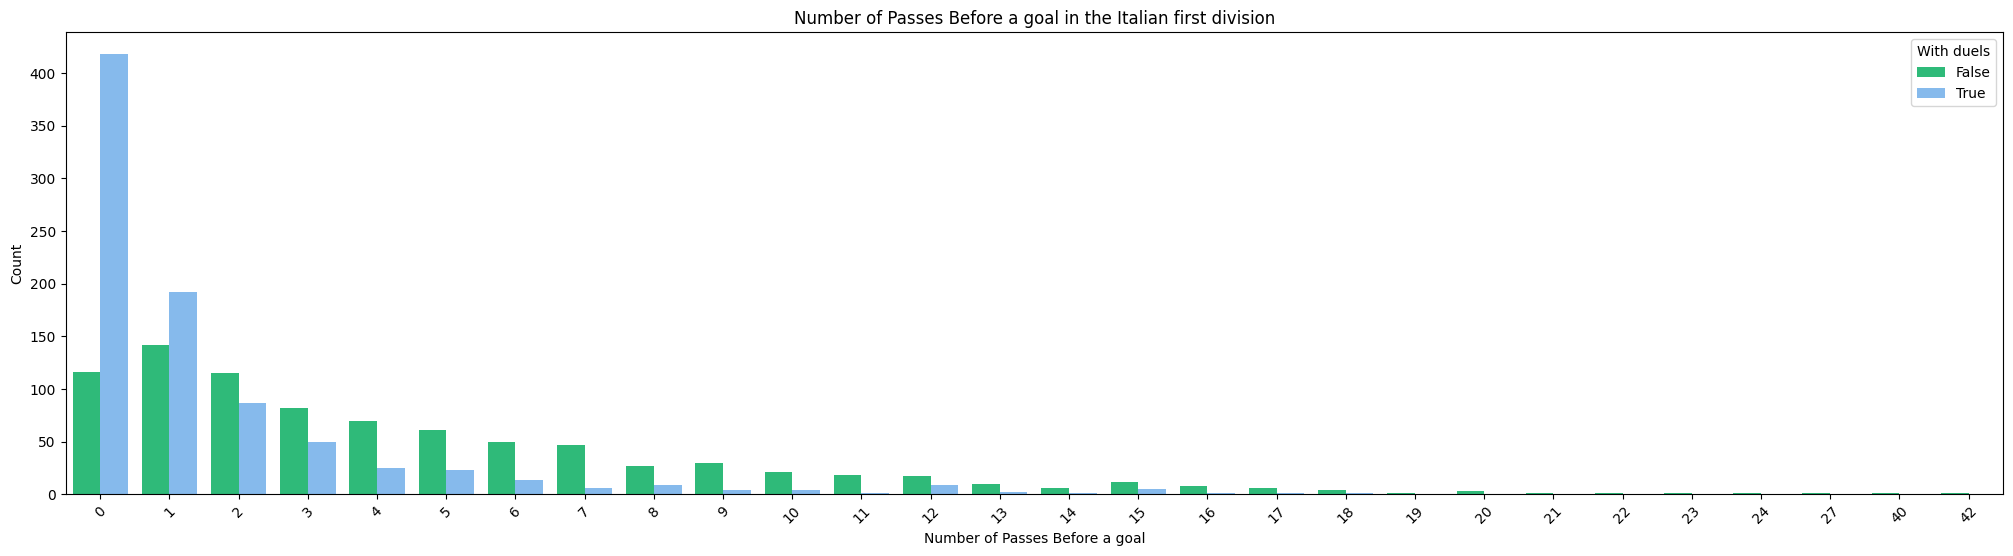

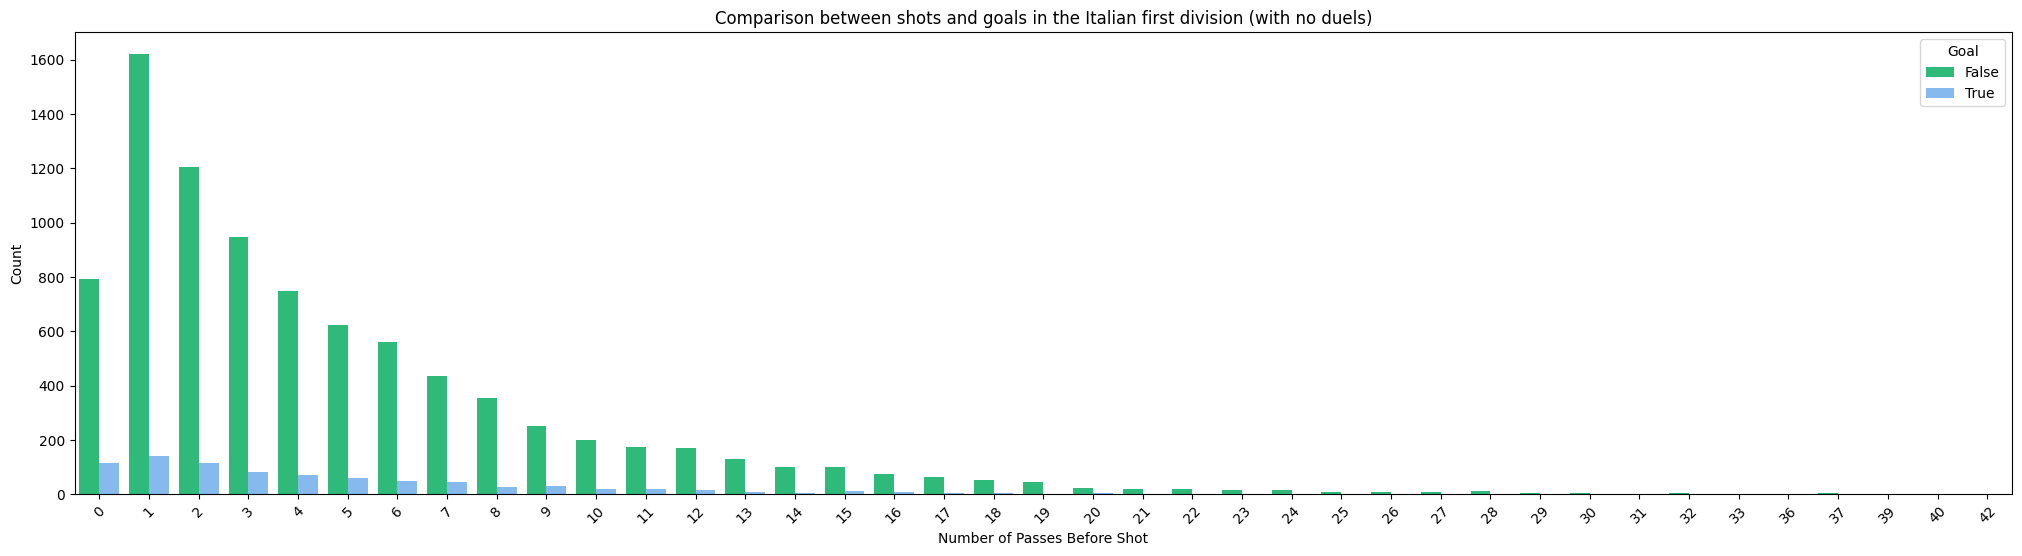

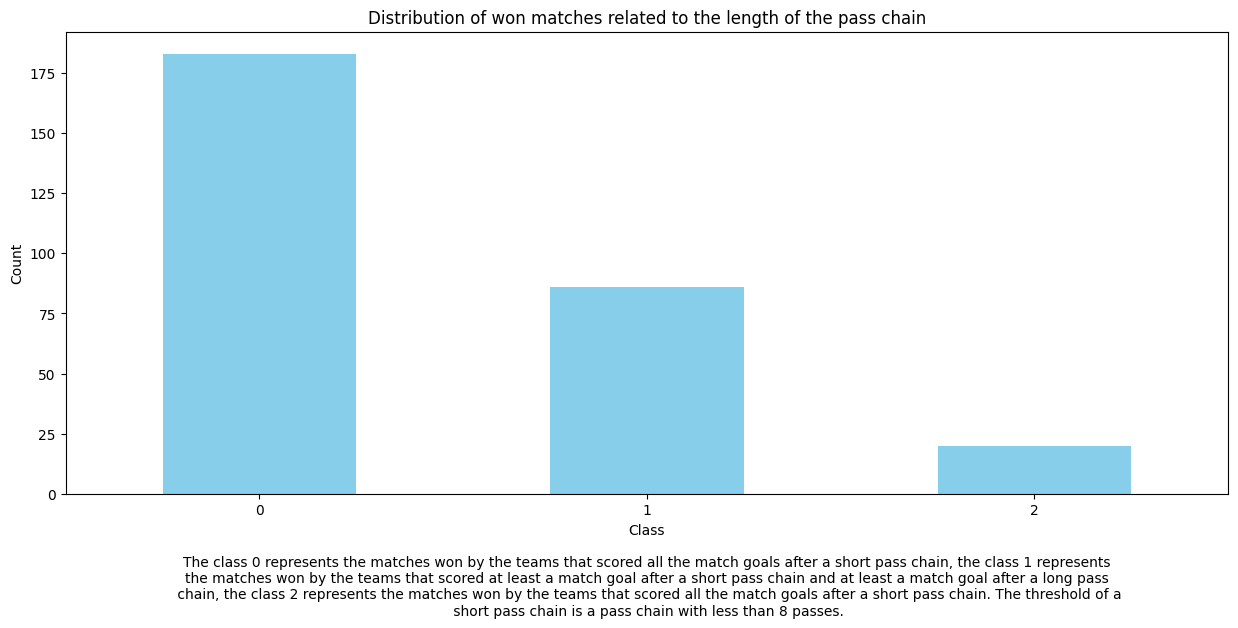

In [11]:
df1, df2, df3, df4 = pass_chain_analysis('Italy', 'Italian first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### English pass chains analysis

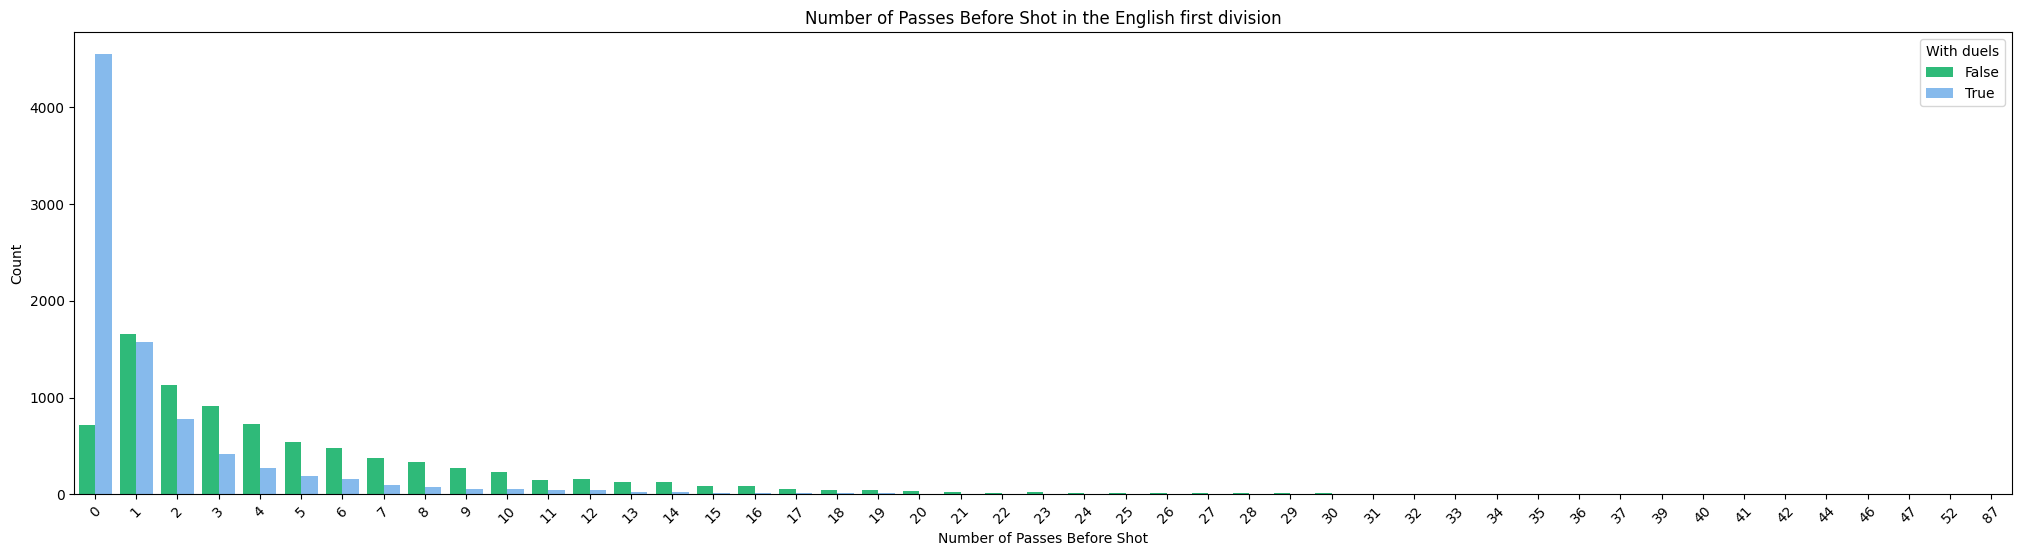

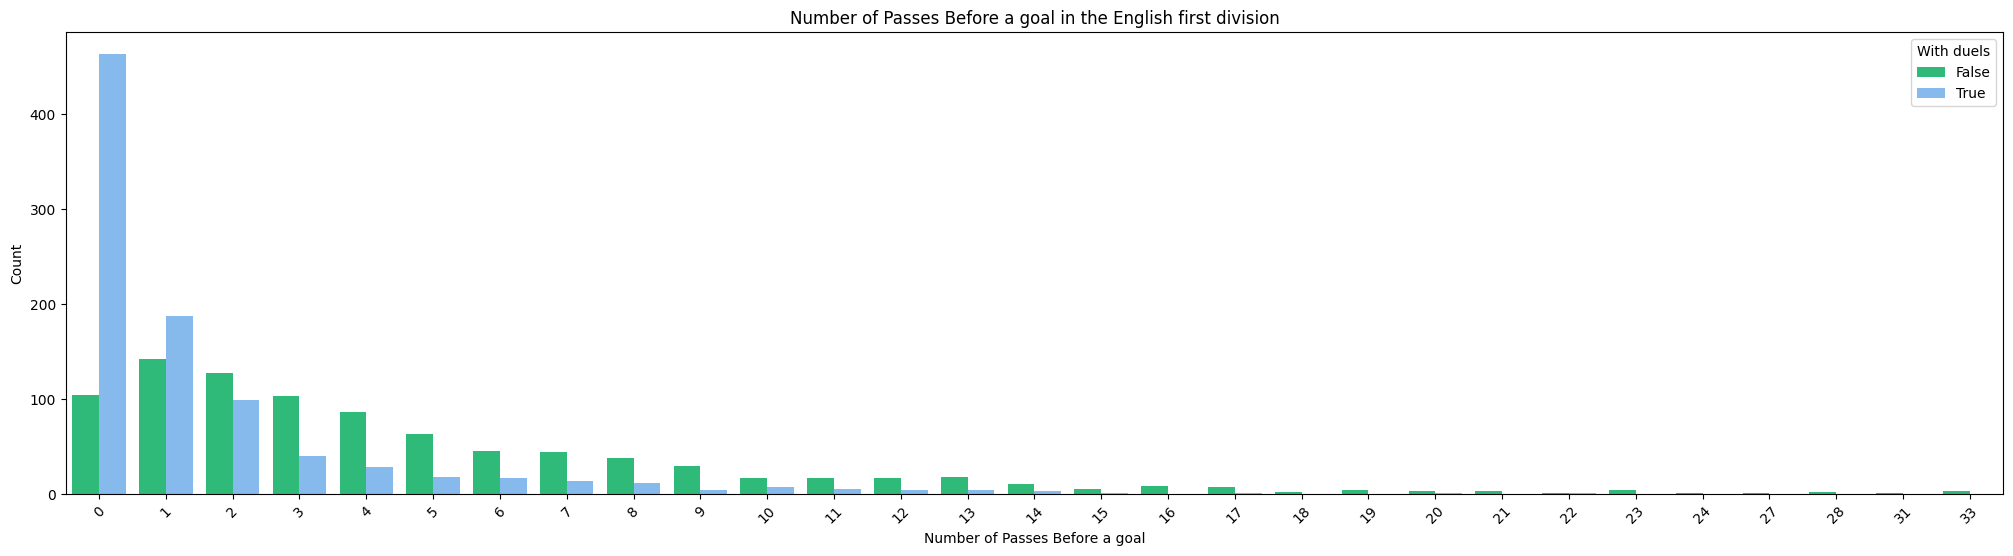

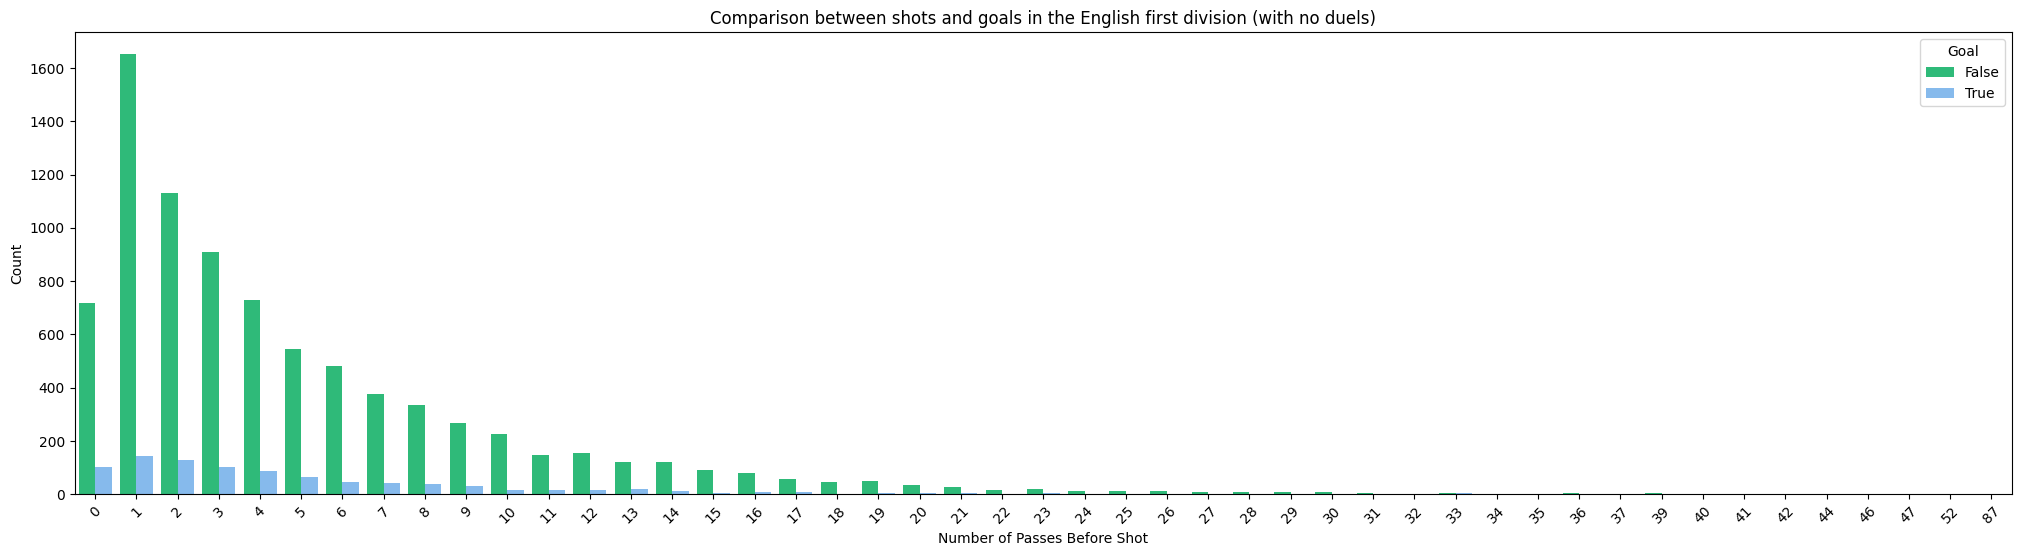

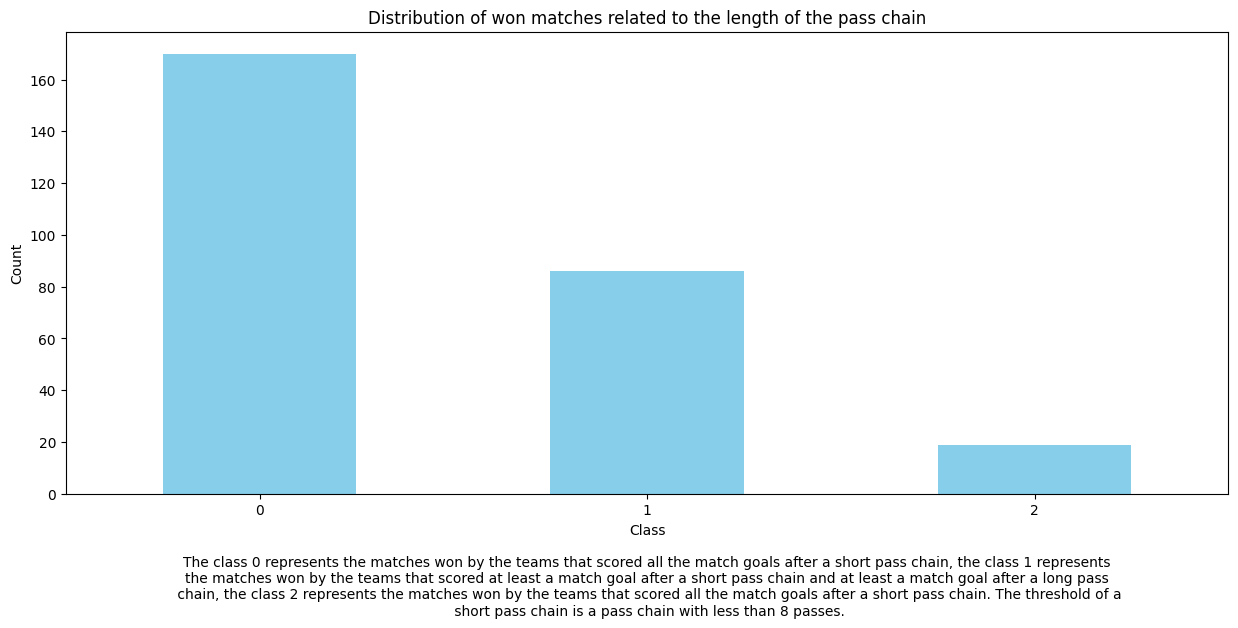

In [12]:
df1, df2, df3, df4 = pass_chain_analysis('England', 'English first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### Spanish pass chain analysis

The following graphs show the distributions of the number of passes before a shot or a goal in the Spanish first division. Considering the characteristics of La Liga, where a football focused more on passing and possession can be observed, it was expected to obtain the highest number of passes before a shot or a goal in this analysis. In fact, considering the results obtained from the cleaned dataset, it can be noted that the number of passes made before a goal is 43, the highest value recorded in this analysis. However, a curious information obtained from these graphs is the fact that the English first division obtains the highest value of number of passes made before a shot, since it would not be expected from a league very focused on physicality and duels.

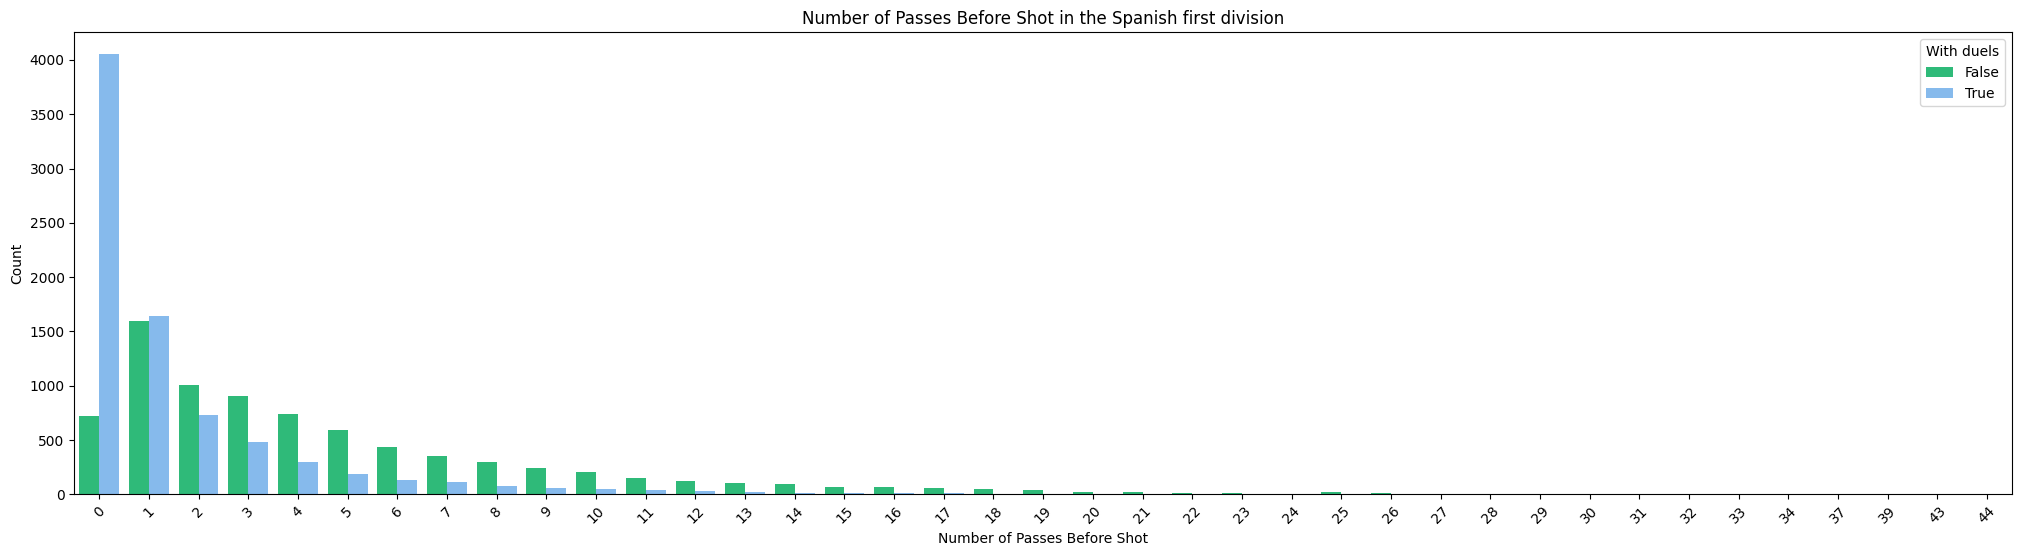

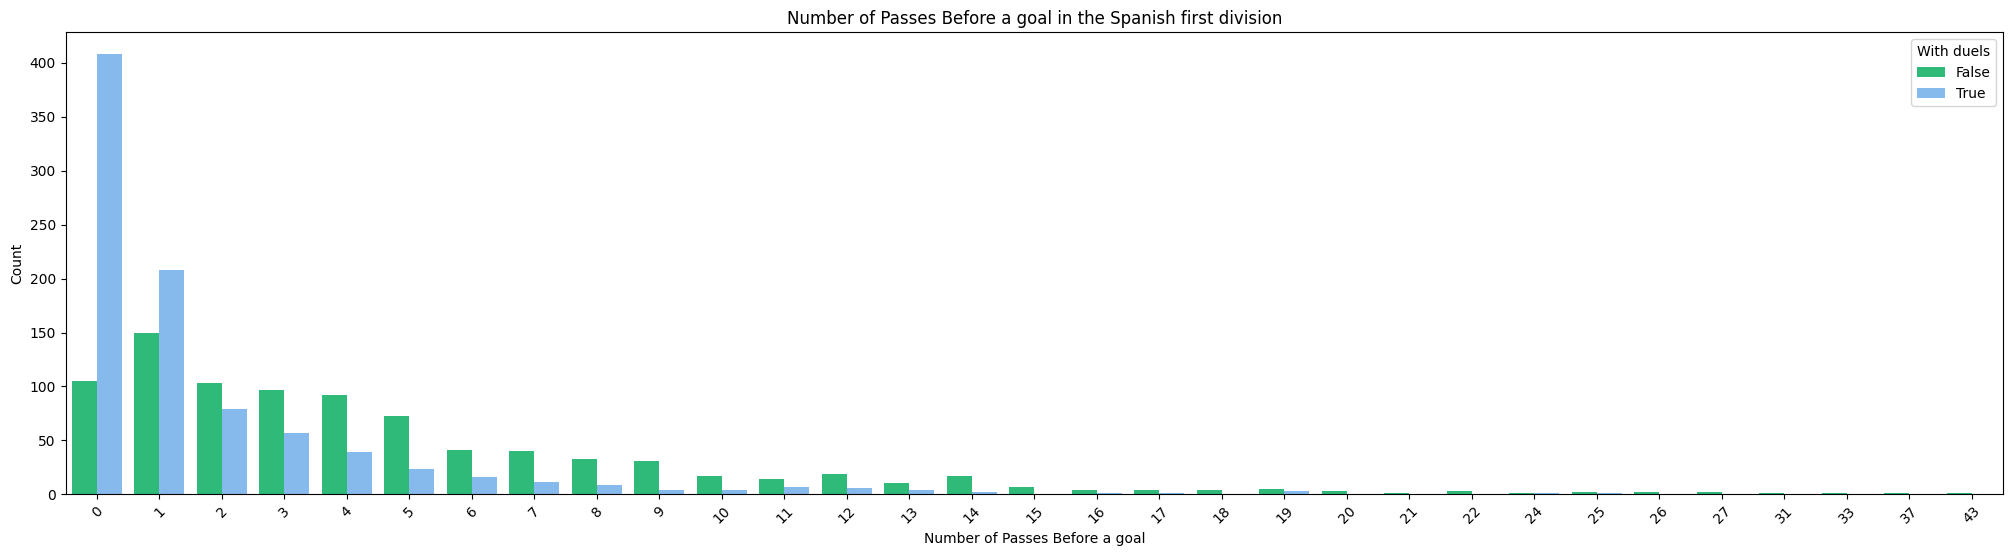

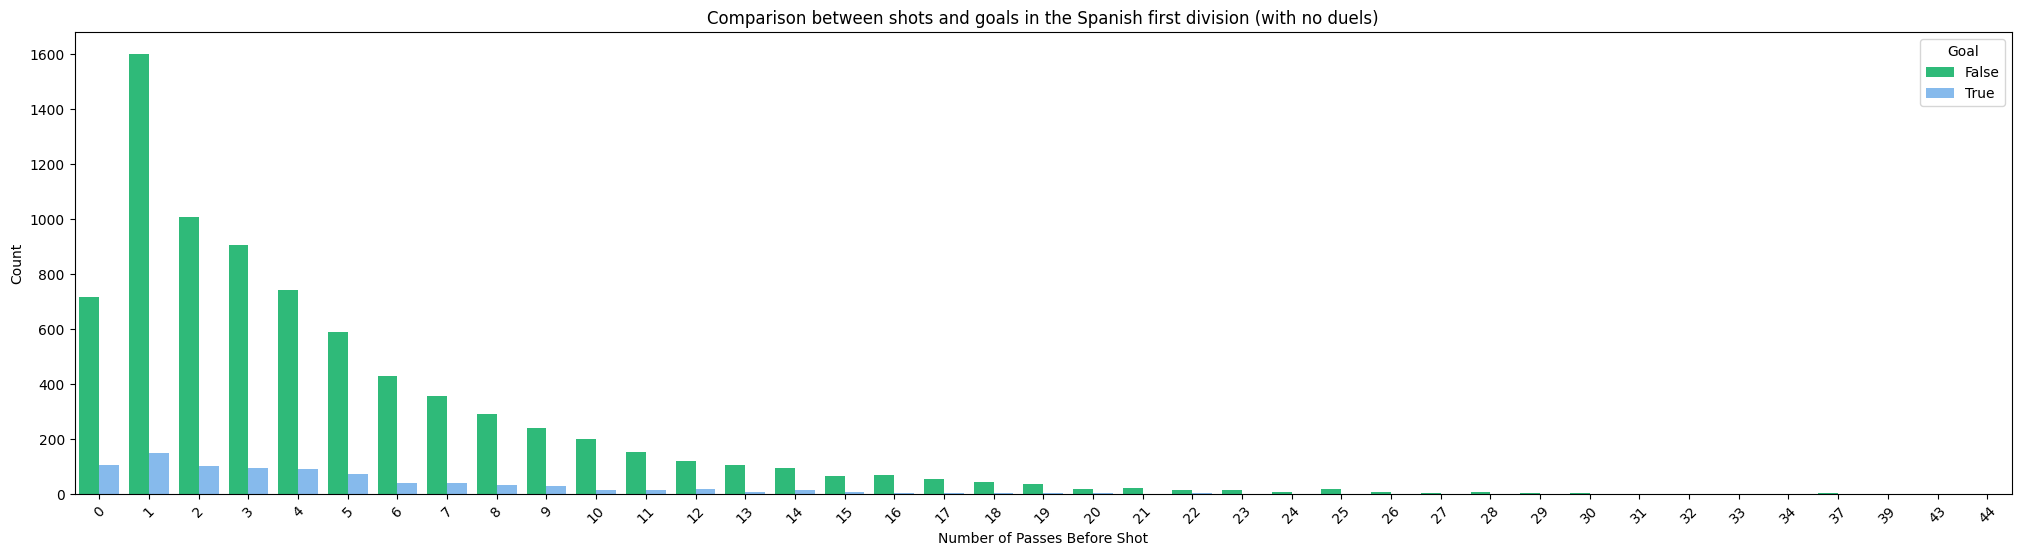

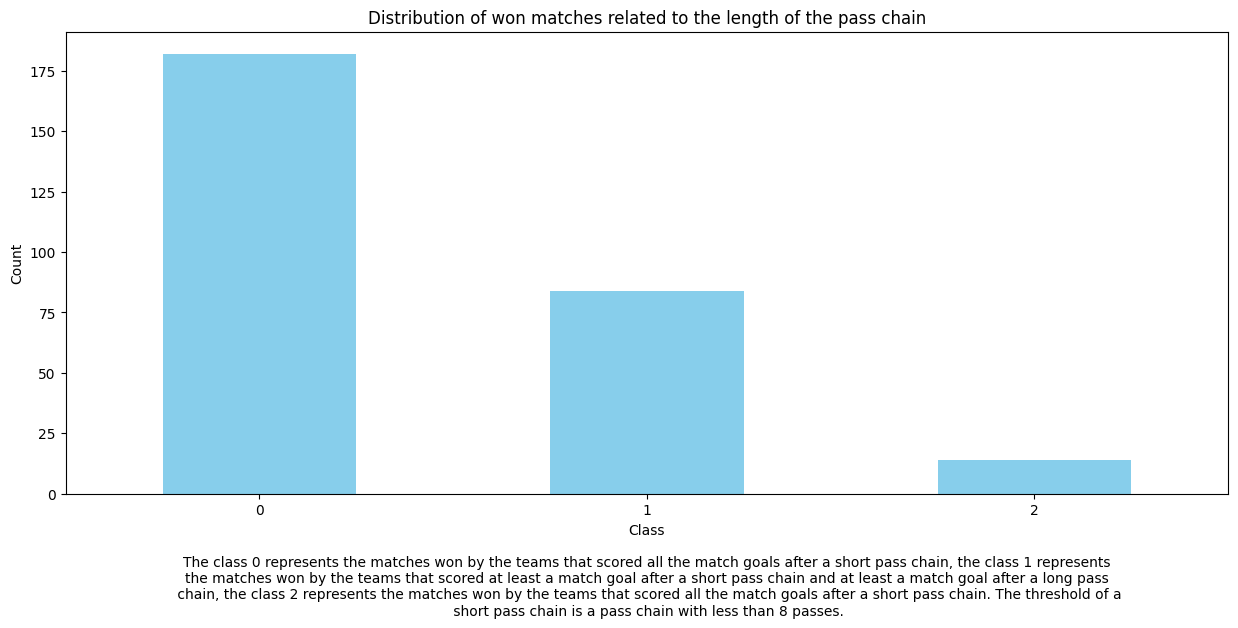

In [13]:
df1, df2, df3, df4 = pass_chain_analysis('Spain', 'Spanish first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### German pass chain analysis

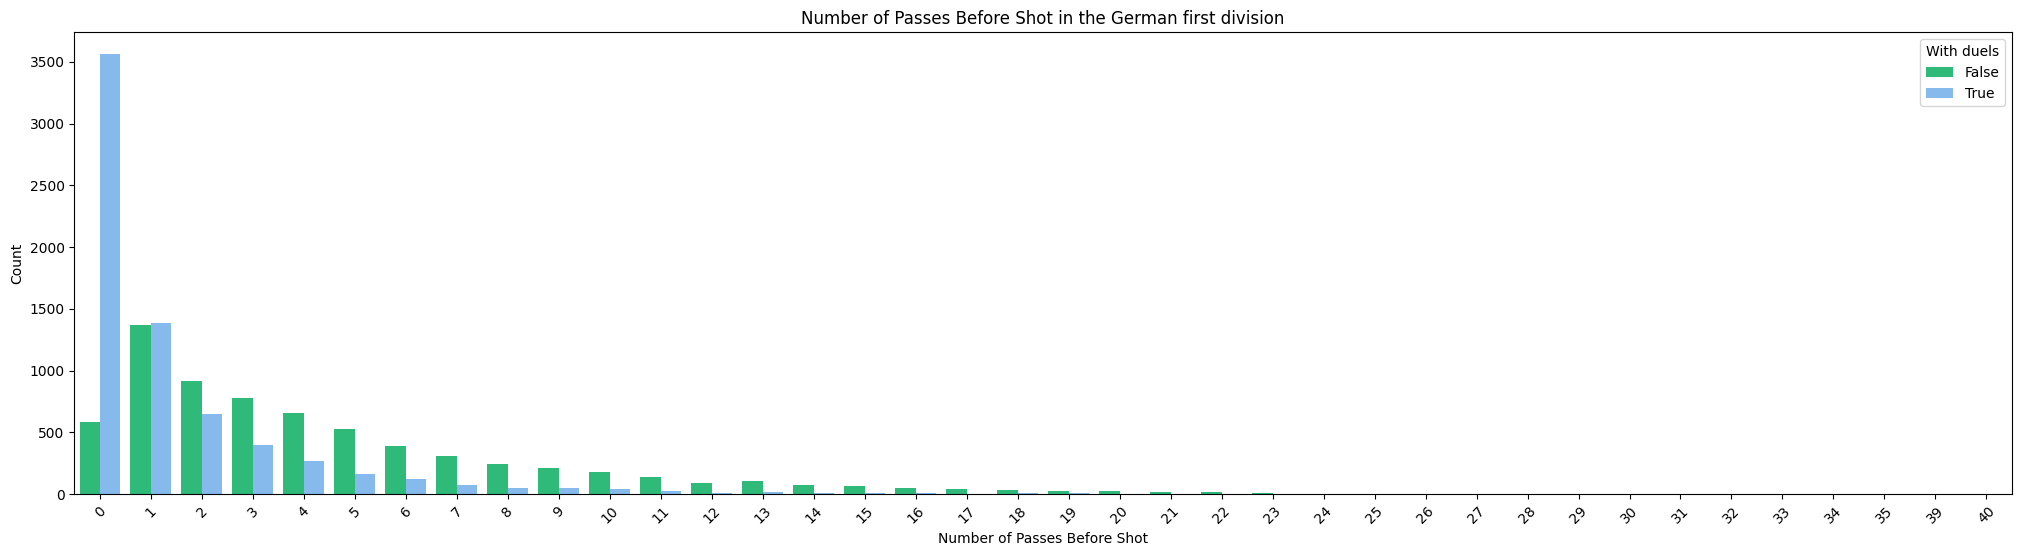

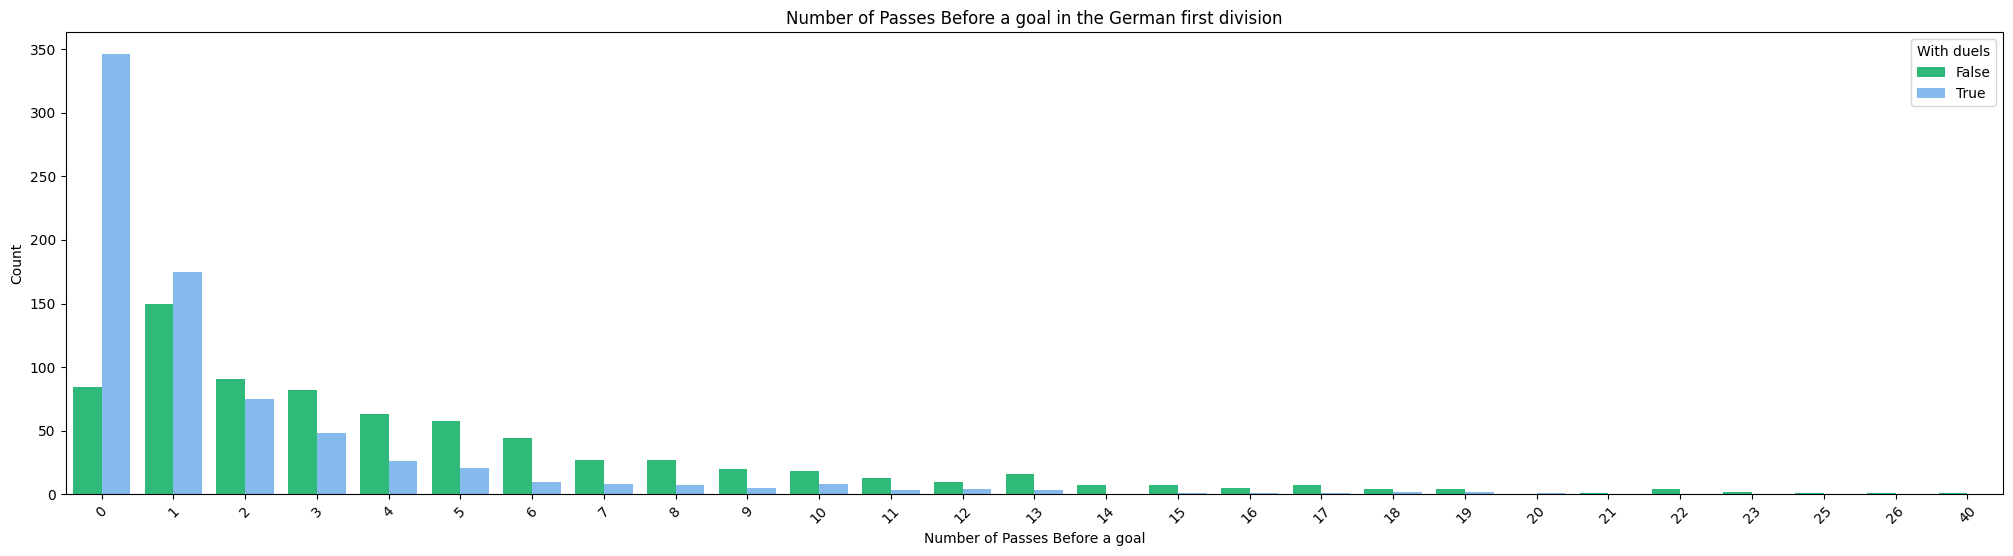

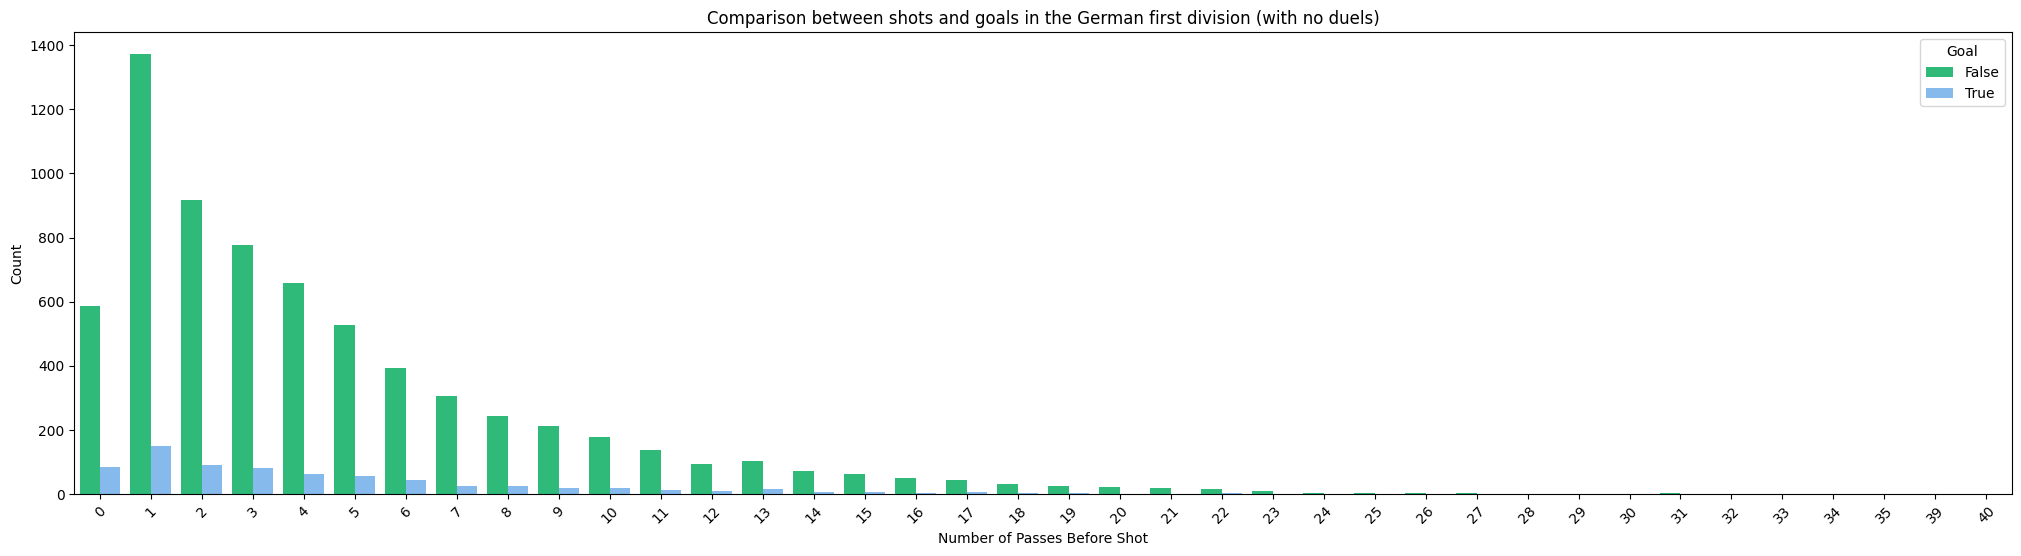

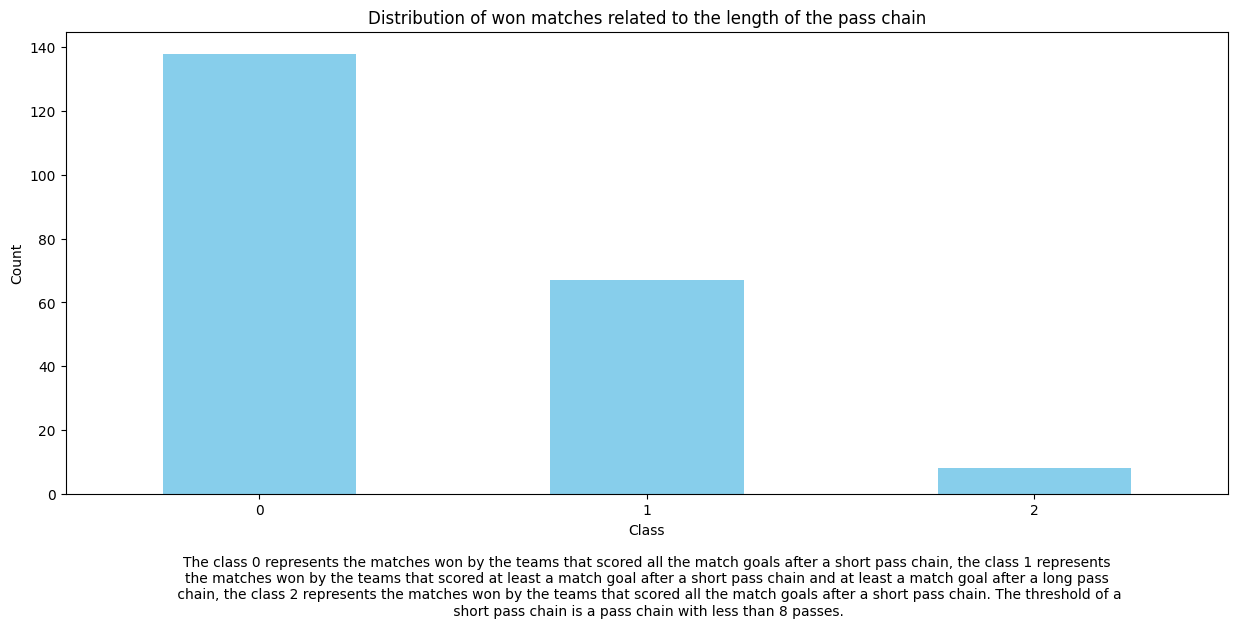

In [14]:
df1, df2, df3, df4 = pass_chain_analysis('Germany', 'German first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### French pass chain analysis

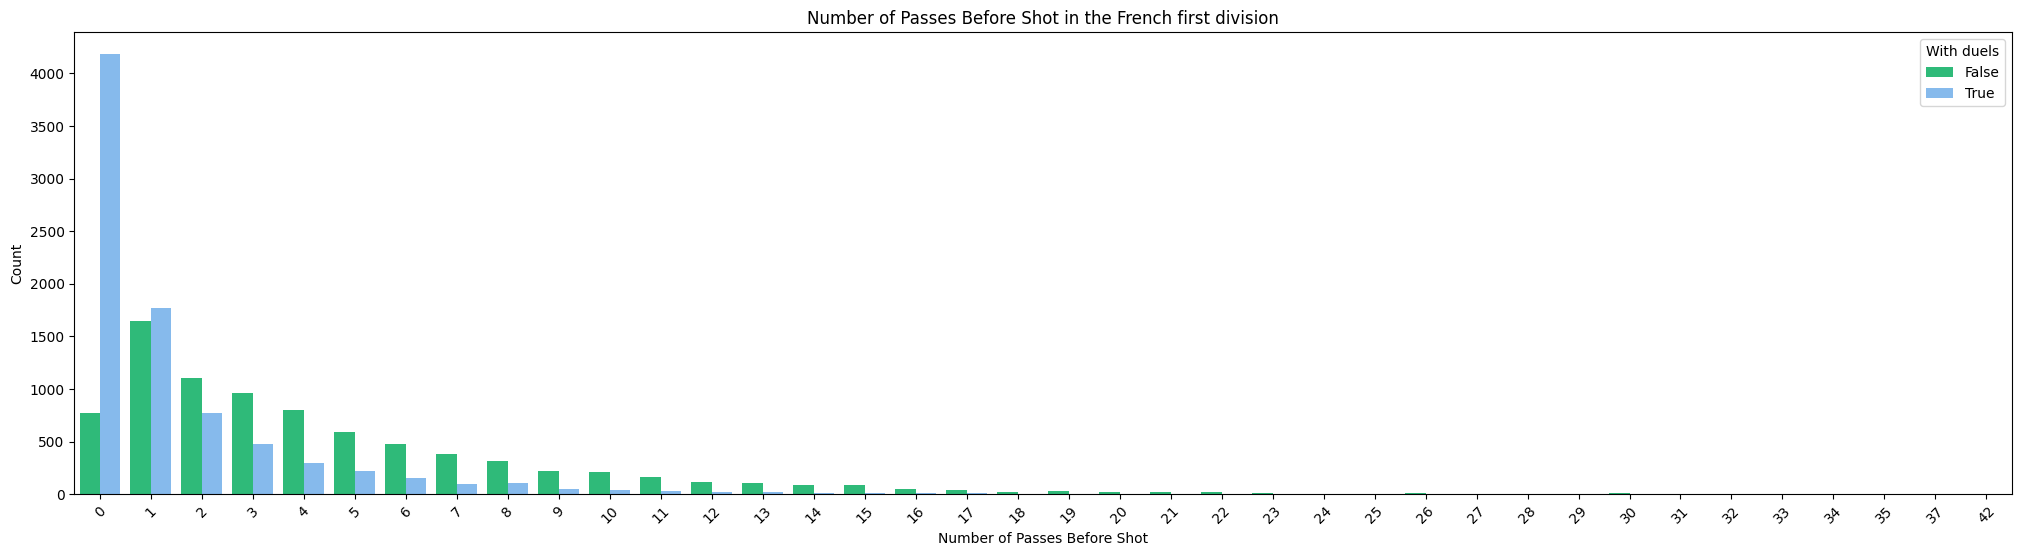

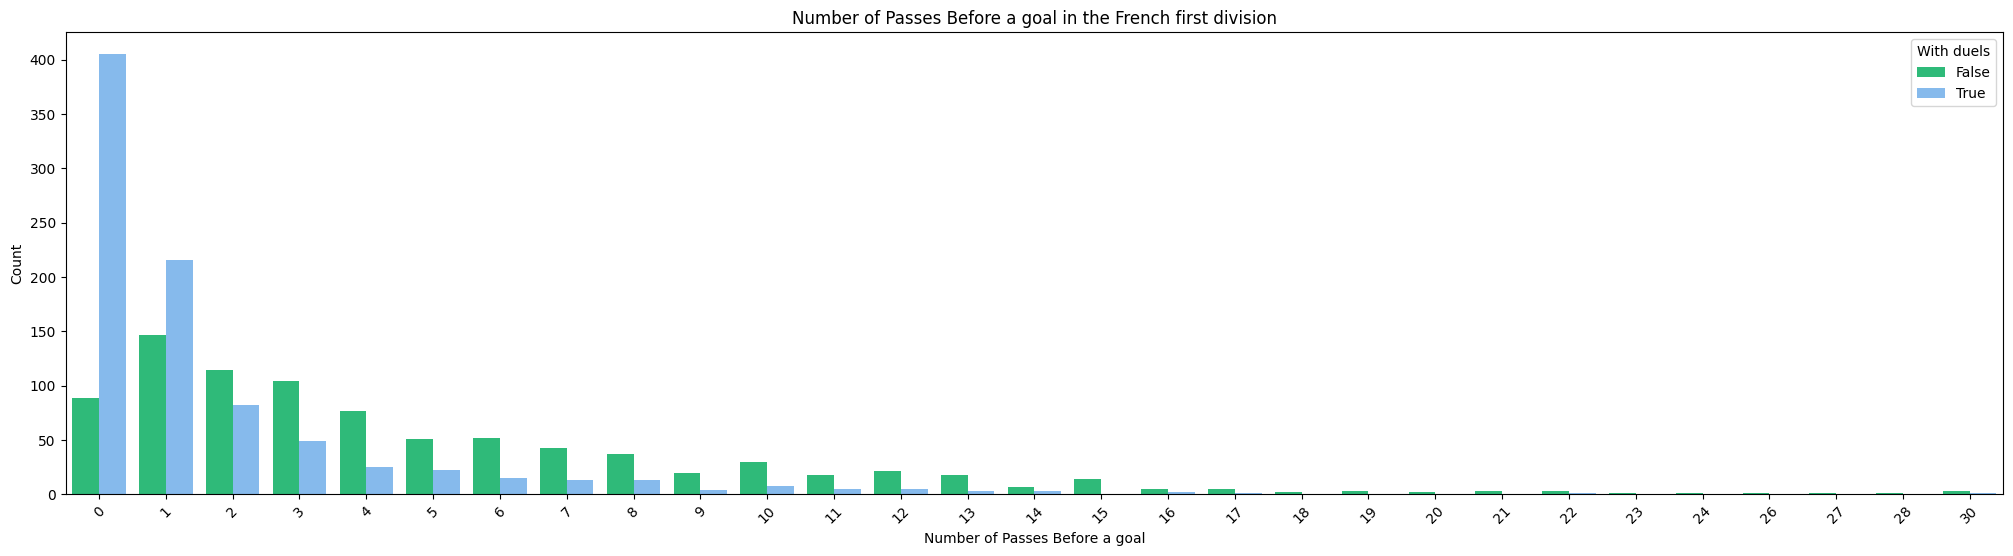

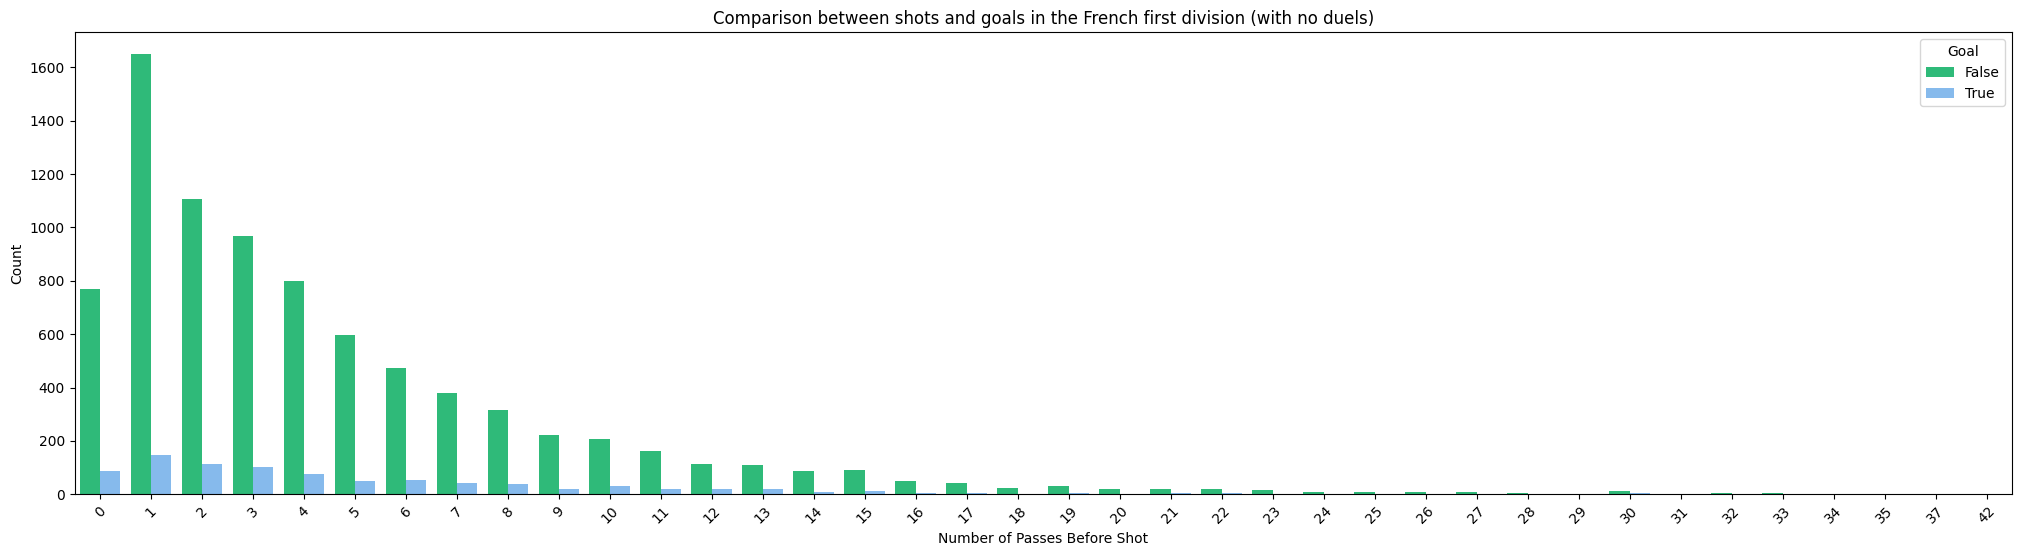

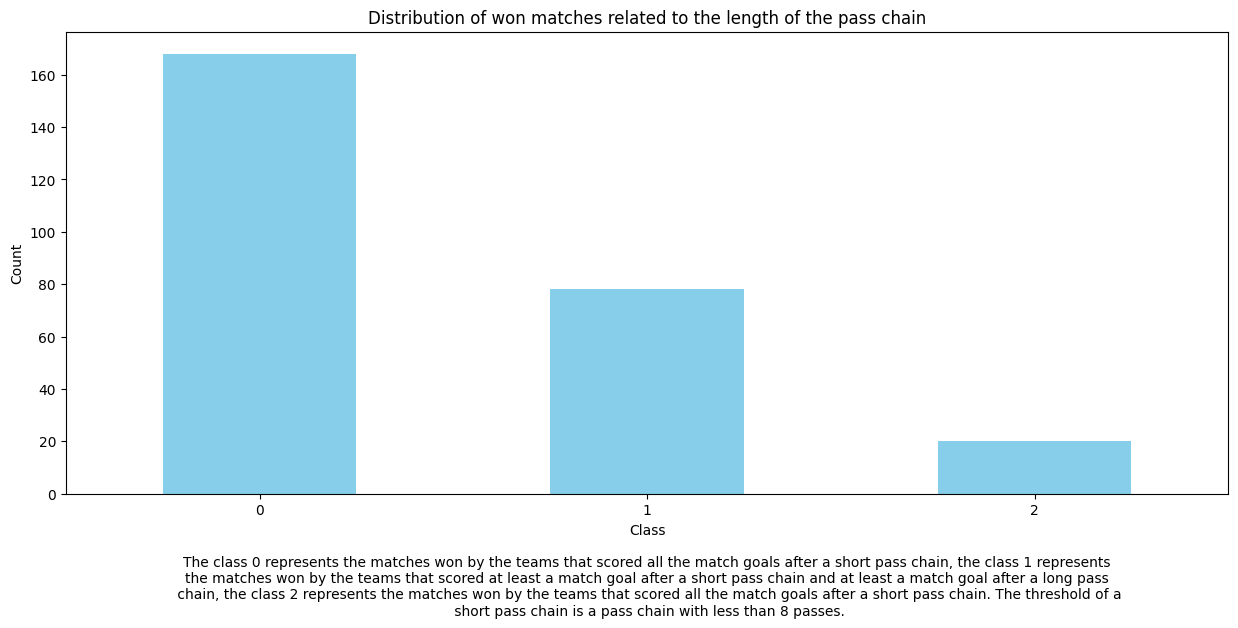

In [15]:
df1, df2, df3, df4 = pass_chain_analysis('France', 'French first division')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### European Championship pass chain analysis

In the analysis of the European Championship and the World Cup, the number of shots and goals is obviously much lower than the values previously seen in the analysis of each individual national football league. It is curious to note that the maximum number of passes before a shot, in both national team competitions, is in line with that of the major European national leagues, while the maximum number of passes made before a goal is much lower than those recorded in the national leagues.

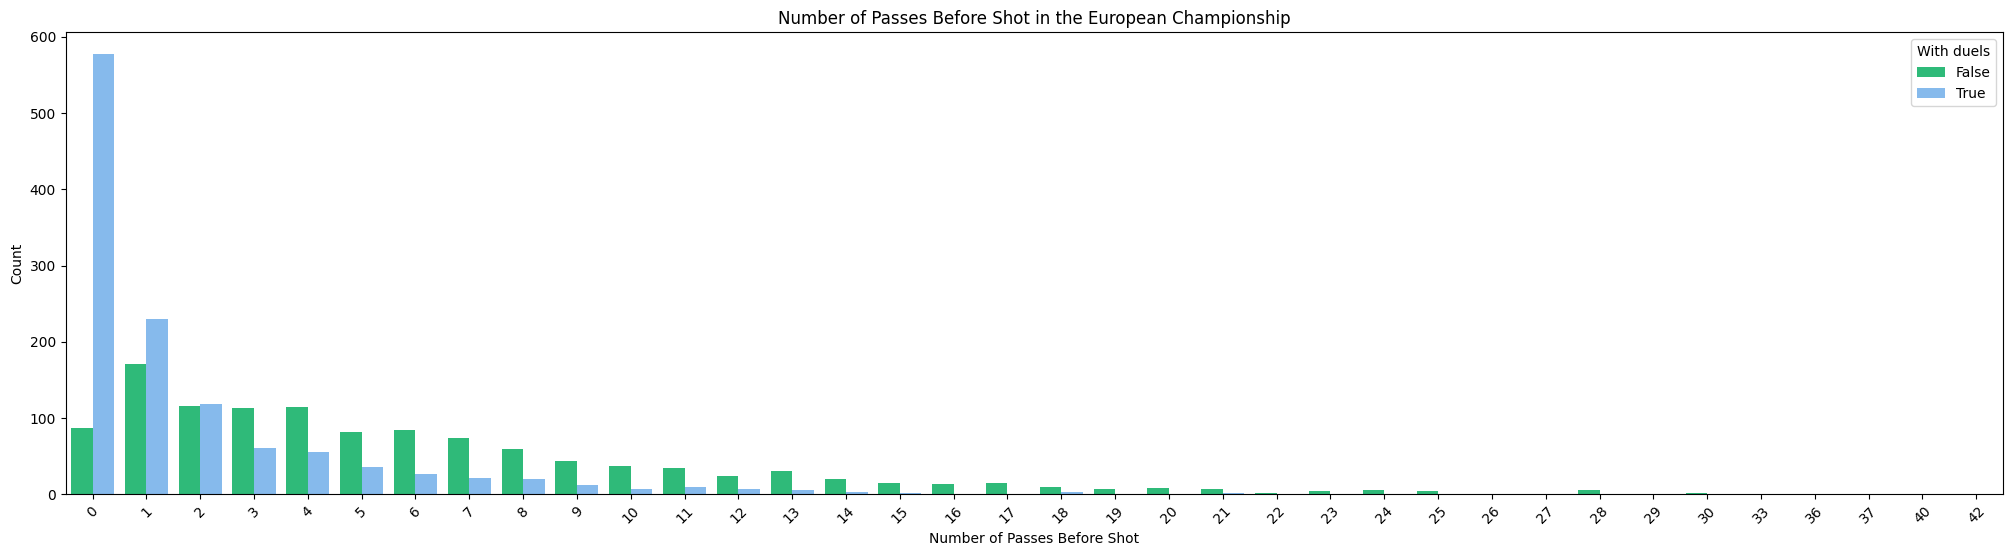

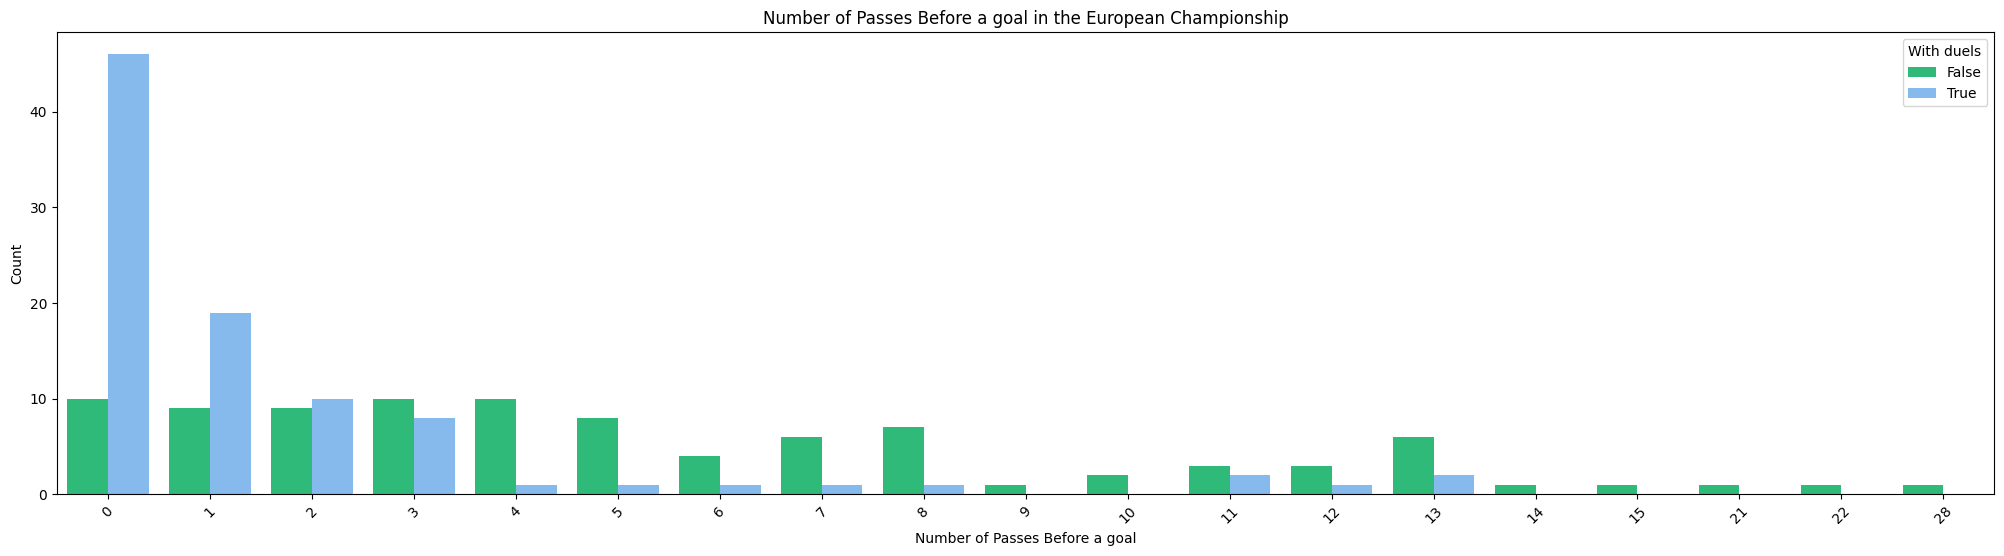

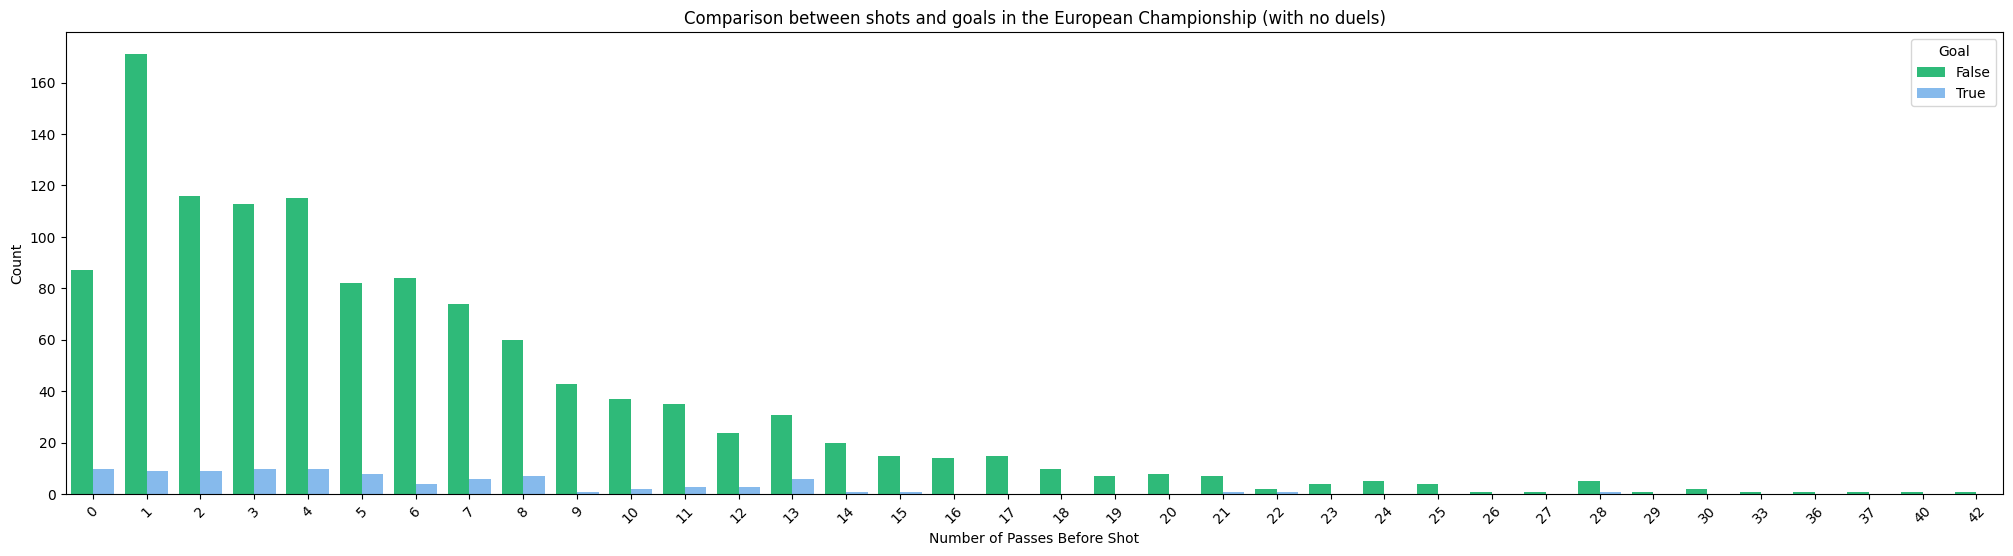

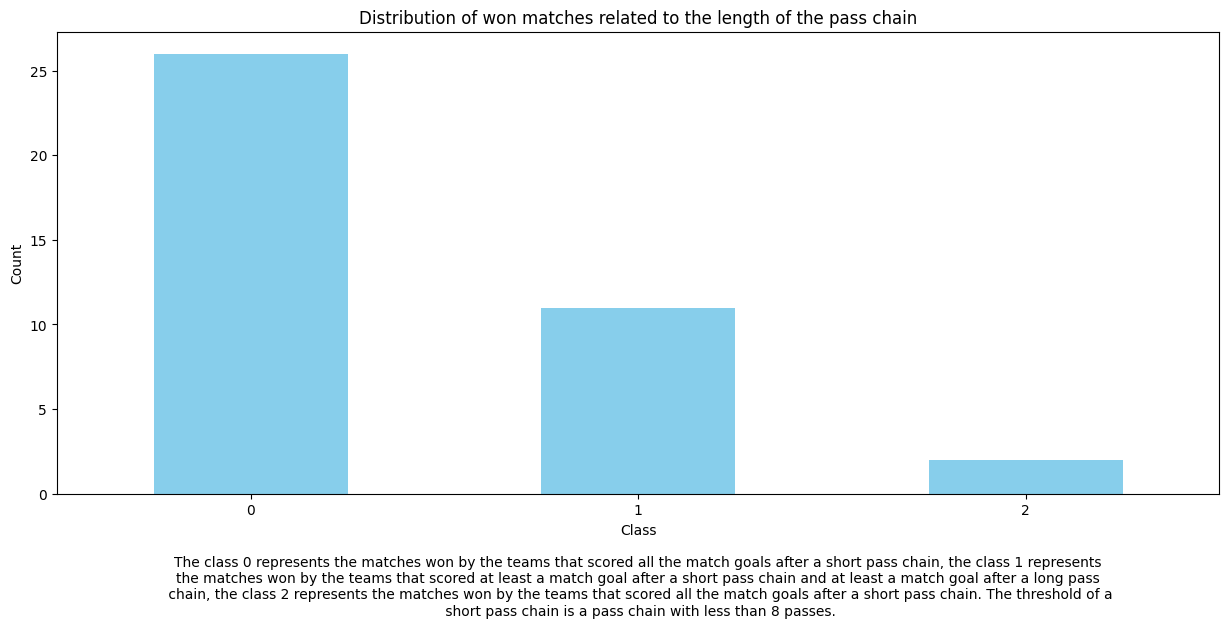

In [16]:
df1, df2, df3, df4 = pass_chain_analysis('European_Championship', 'European Championship')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### World Cup pass chain analysis

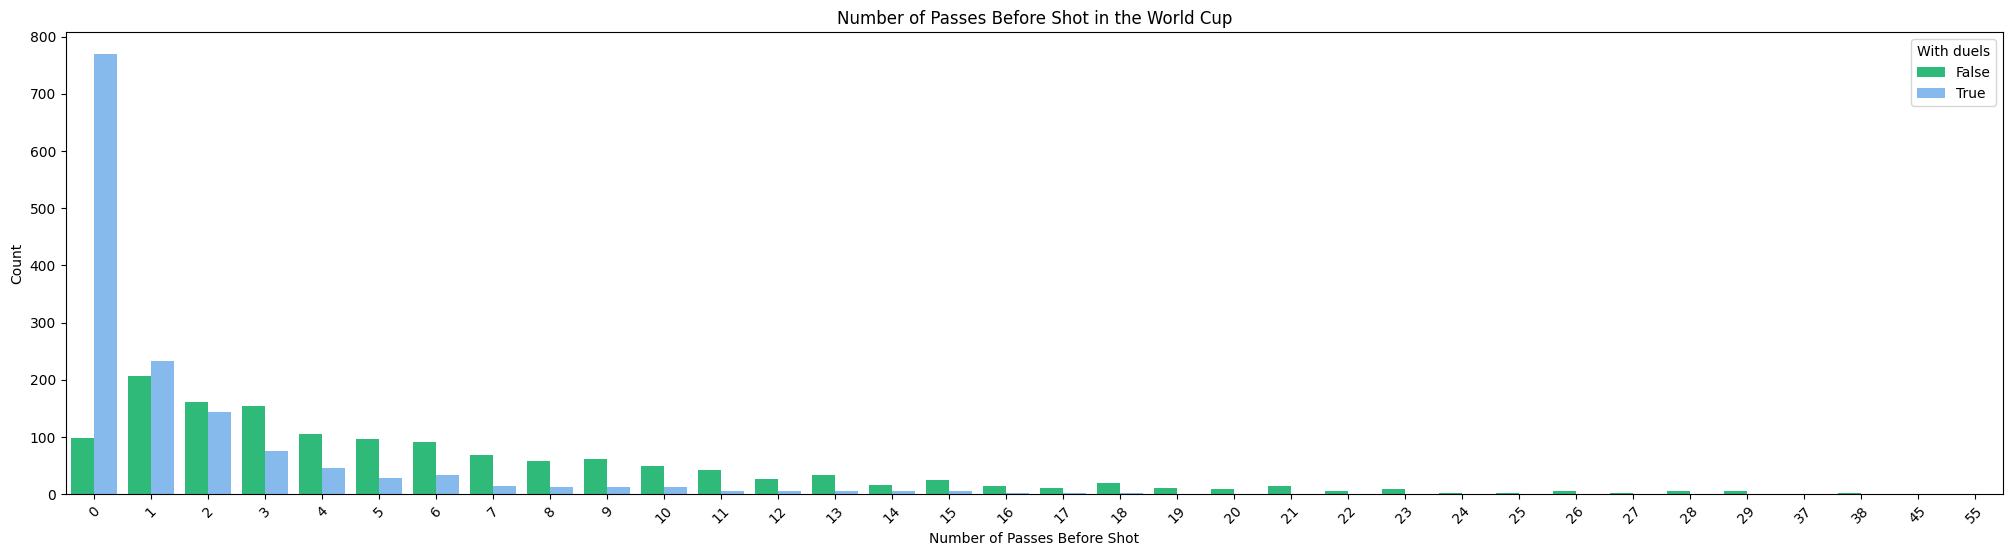

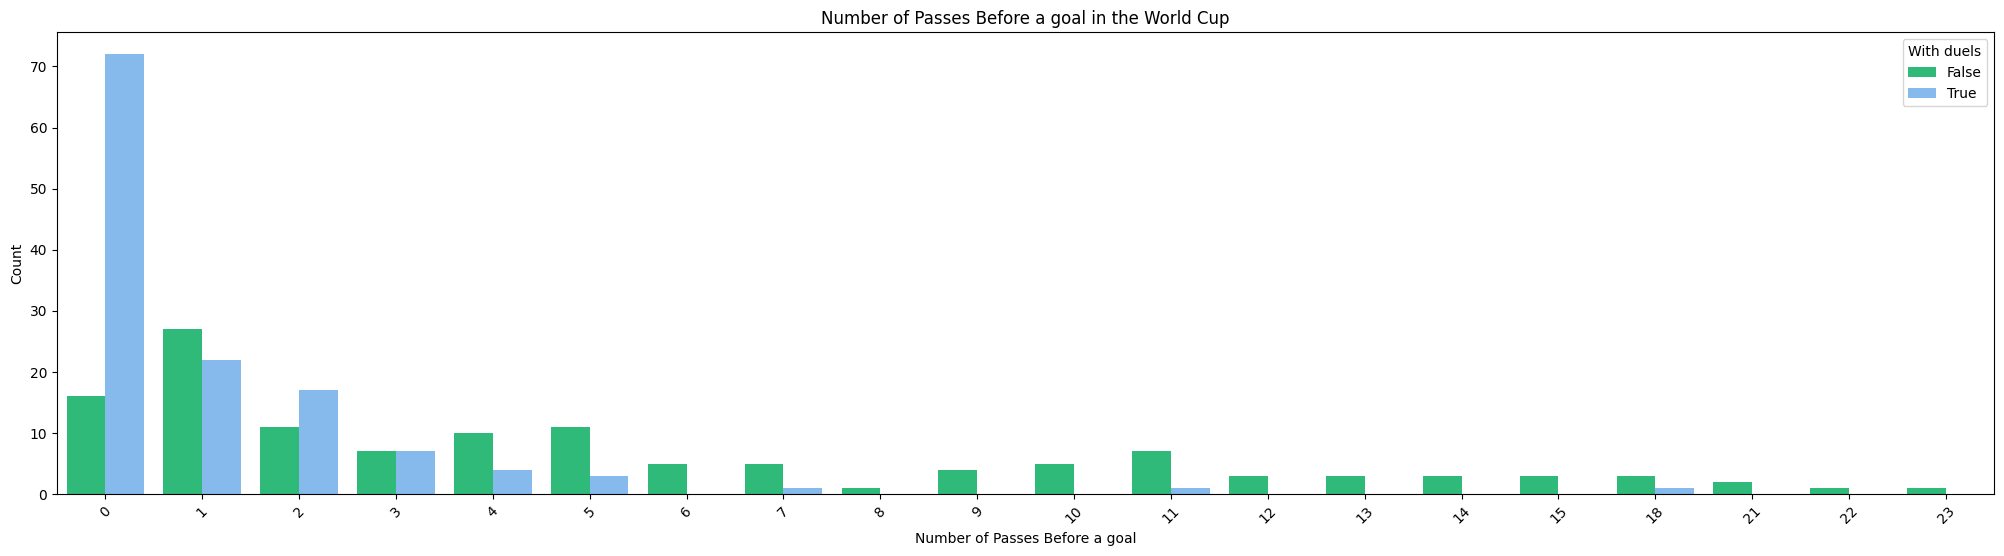

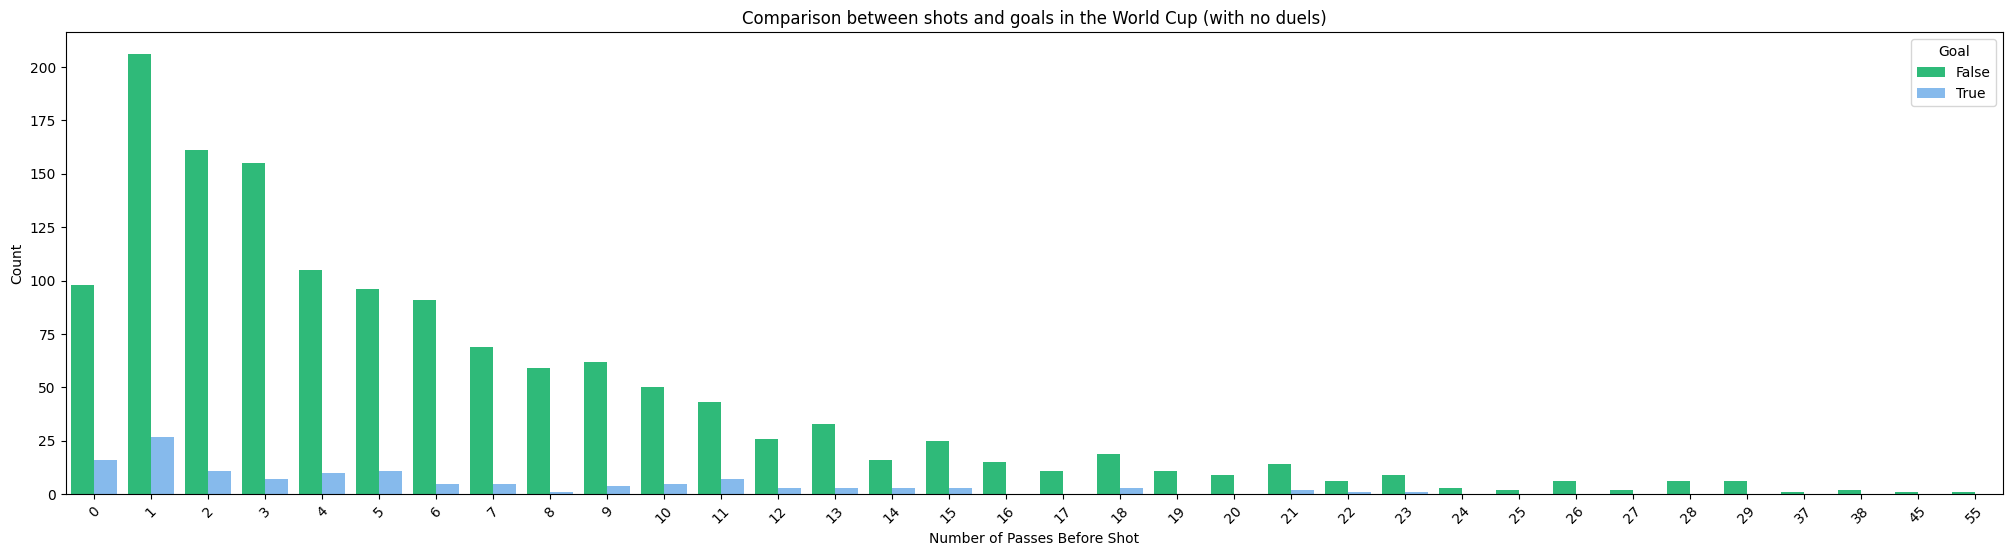

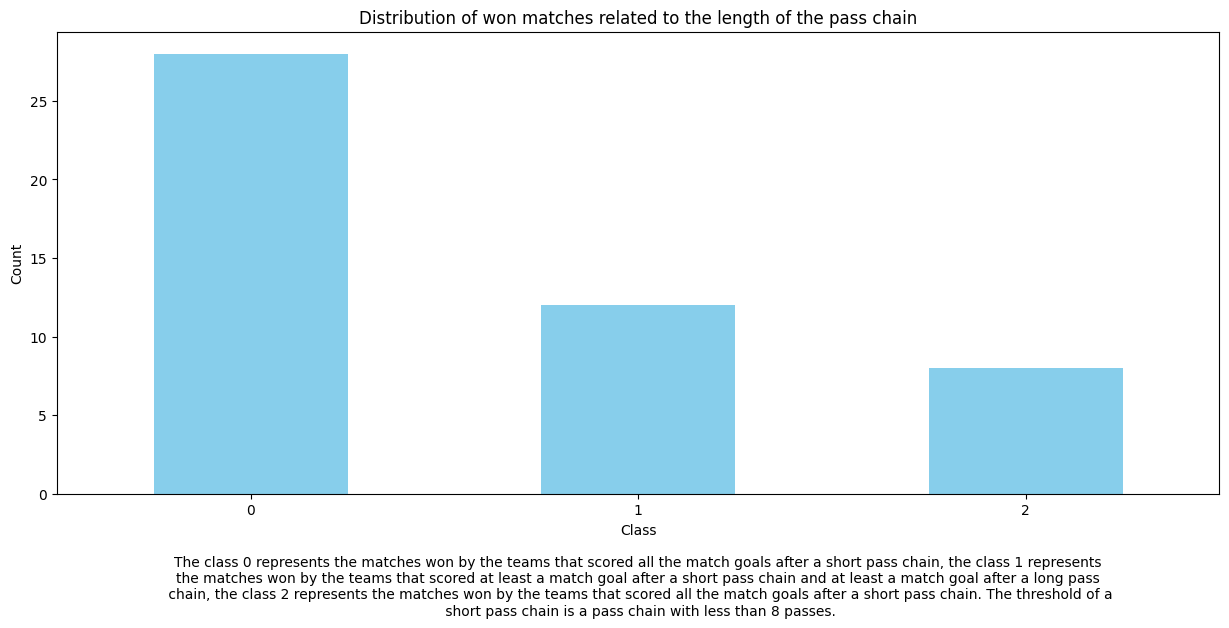

In [17]:
df1, df2, df3, df4 = pass_chain_analysis('World_Cup', 'World Cup')
total_passes_counts = pd.concat([total_passes_counts, df1])
total_goals_passes_counts = pd.concat([total_goals_passes_counts, df2])
total_comparison = pd.concat([total_comparison, df3])
competition_wins = pd.concat([competition_wins, df4])

### Total analysis

The analysis carried out in this notebook shows that, apparently, shorter pass chains lead to a higher probability of taking a shot or scoring a goal. Obviously, it is clear that when a team has prolonged possession, the opposing team tries to break the pass chain and regain possession. In fact, very long pass chains that lead to a shot on goal are very often due to the fact that the opposing team is able to defend very well and therefore the team trying to score needs to find space and then attack and try to score. However, these behaviors have seemed to be futile and inefficient, since in a small sample of matches, such as those of the European Football Championship (consisting of 51 matches) and the World Cup (consisting of 64 matches), it was noted that the maximum number of passes made before a goal is around 25.

This intuition was actually confirmed by also checking the distribution of victories in each individual competition. In fact, the number of matches won with only goals scored with a pass chain of length less than 8 is always significantly higher than matches where the goals of the winning team were scored with long pass chains.

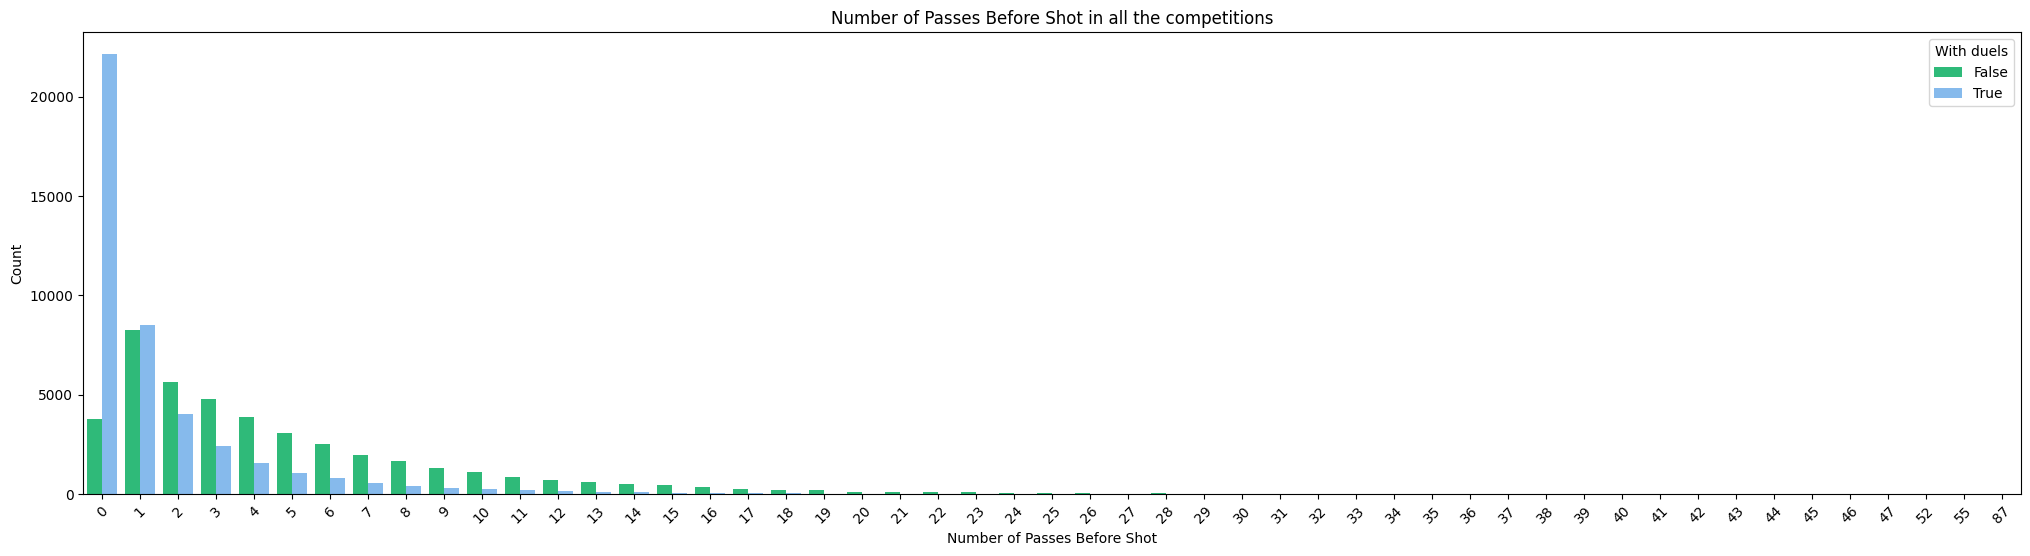

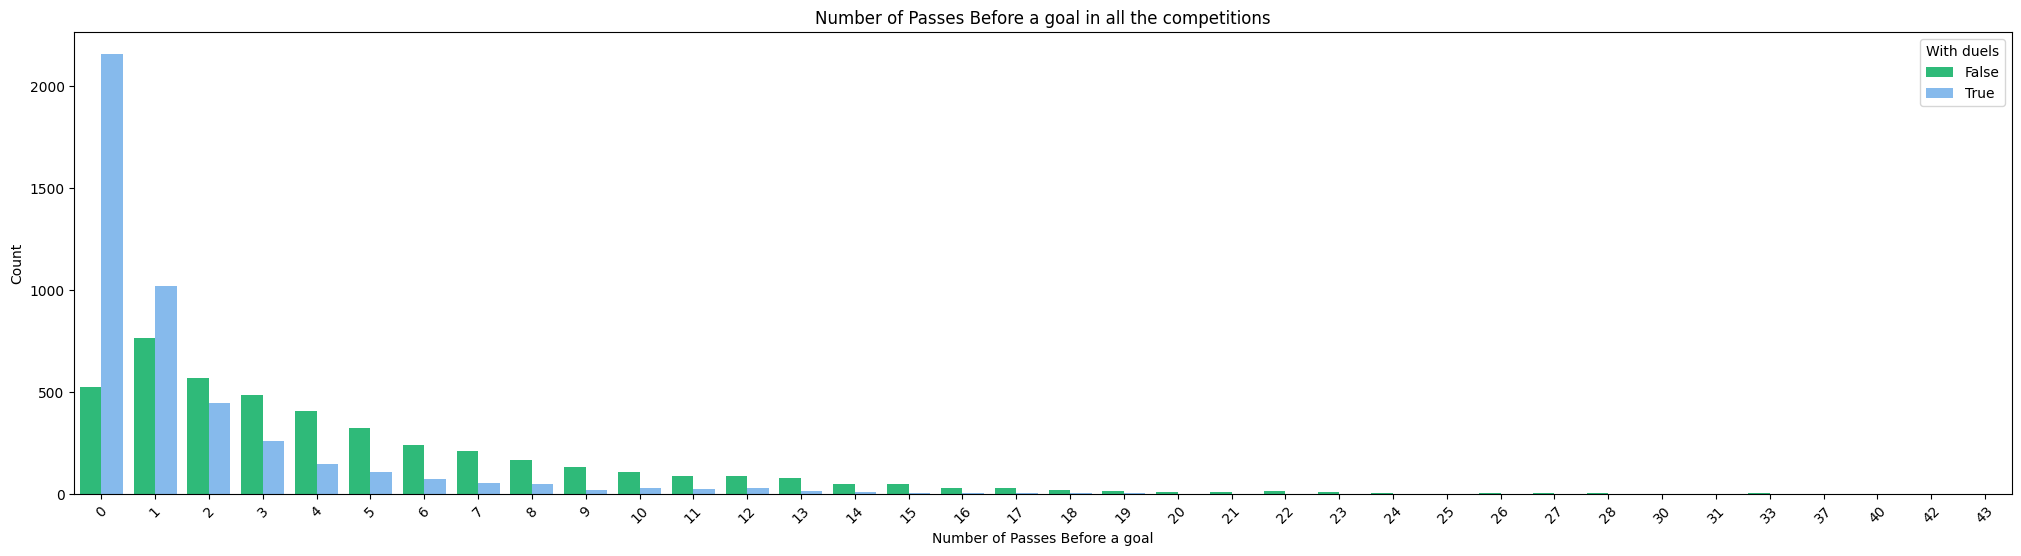

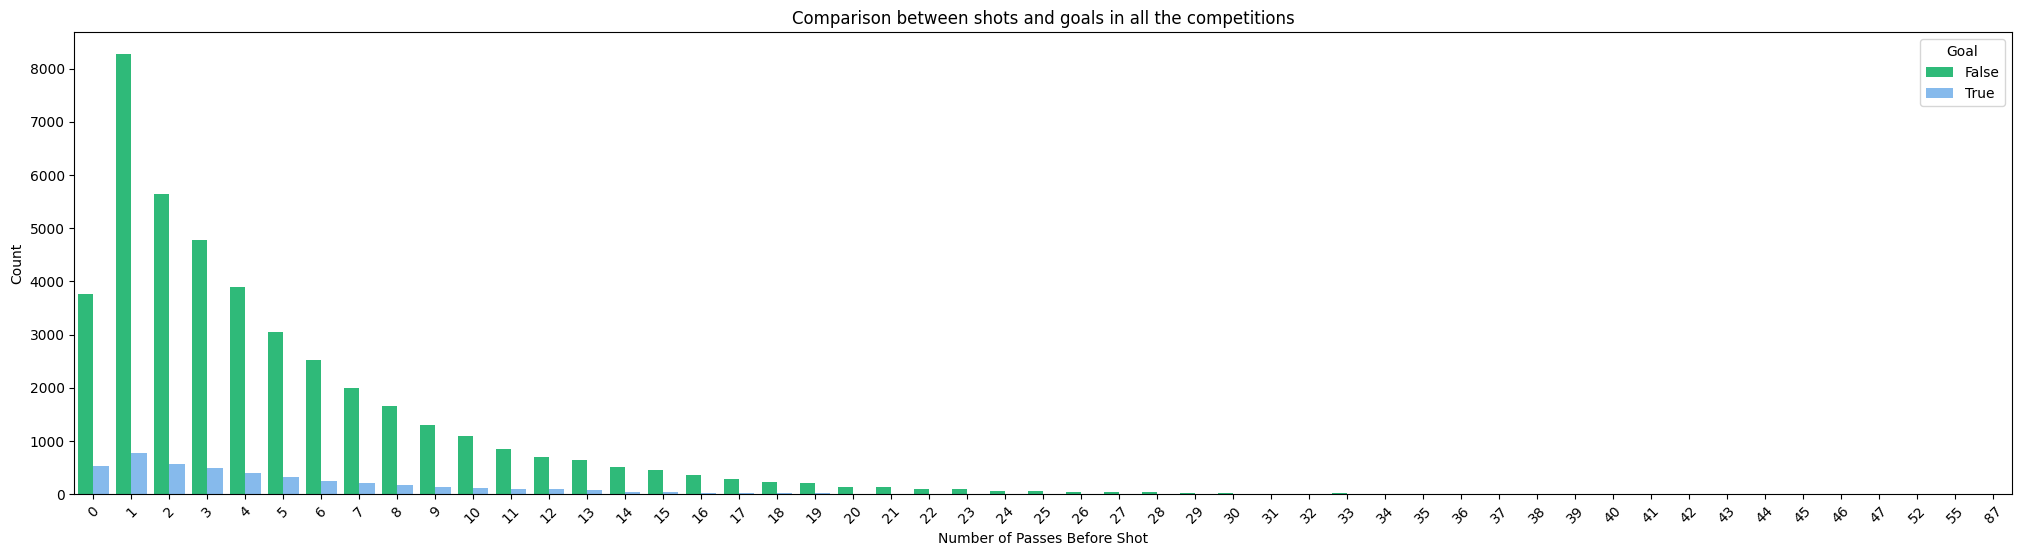

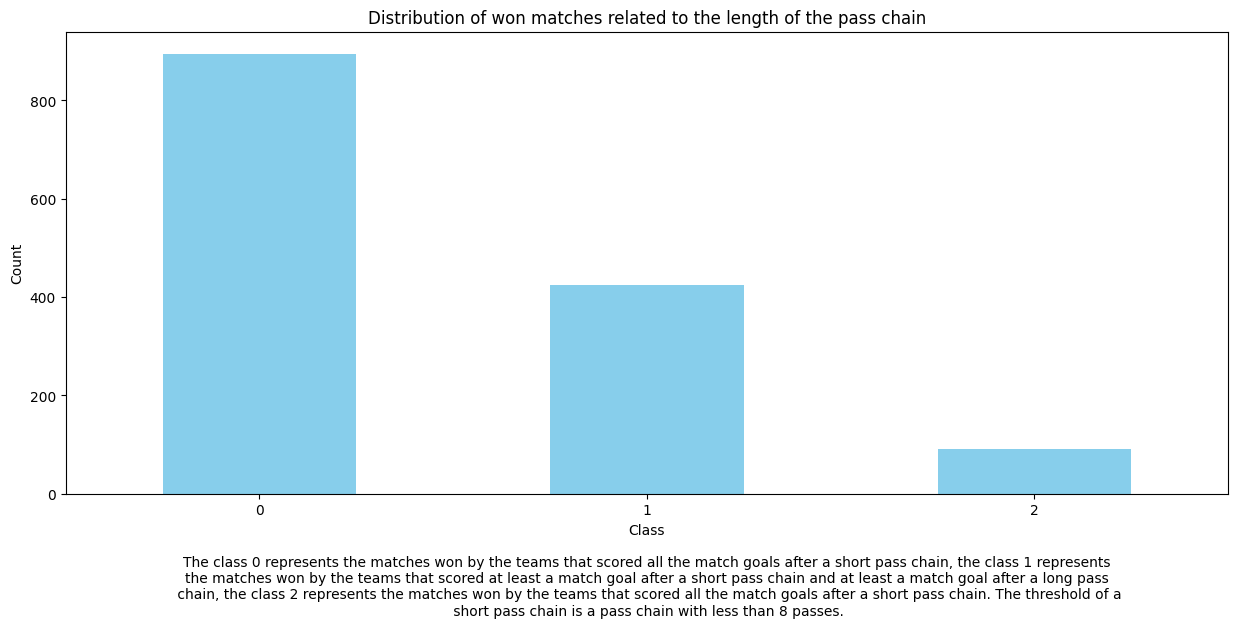

In [18]:
total_analysis(total_passes_counts, total_goals_passes_counts, total_comparison, competition_wins)